In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fetalhr/CTG.csv


# Preprocessing

In [2]:
df = pd.read_csv(r'/kaggle/input/fetalhr/CTG.csv')
df

# %% [code] {"execution":{"iopub.status.busy":"2024-11-24T18:44:41.501415Z","iopub.execute_input":"2024-11-24T18:44:41.501825Z","iopub.status.idle":"2024-11-24T18:44:41.509920Z","shell.execute_reply.started":"2024-11-24T18:44:41.501789Z","shell.execute_reply":"2024-11-24T18:44:41.508778Z"}}
df=df.drop(["FileName","Date","SegFile","b","e"],axis=1)

# %% [code] {"execution":{"iopub.status.busy":"2024-11-24T18:44:48.829882Z","iopub.execute_input":"2024-11-24T18:44:48.830402Z","iopub.status.idle":"2024-11-24T18:44:48.841008Z","shell.execute_reply.started":"2024-11-24T18:44:48.830354Z","shell.execute_reply":"2024-11-24T18:44:48.839578Z"}}
df=df.dropna()

In [3]:
df = df.drop_duplicates()

# Print the shape of the DataFrame to verify
print(f"DataFrame shape after removing missing values and duplicates: {df.shape}")

DataFrame shape after removing missing values and duplicates: (2114, 35)


In [4]:
df_copy = df.copy()

# %% [code] {"execution":{"iopub.status.busy":"2024-11-24T18:45:14.298162Z","iopub.execute_input":"2024-11-24T18:45:14.299255Z","iopub.status.idle":"2024-11-24T18:45:27.310722Z","shell.execute_reply.started":"2024-11-24T18:45:14.299174Z","shell.execute_reply":"2024-11-24T18:45:27.309368Z"}}
!pip install imblearn
from imblearn.over_sampling import SMOTE


NSP
1.0    1648
2.0     292
3.0     174
Name: count, dtype: int64


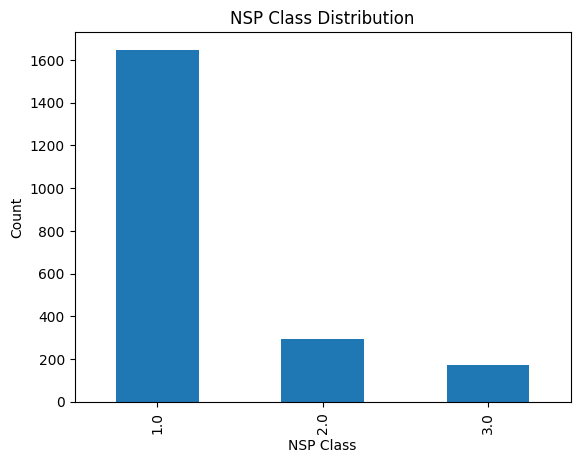

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_copy is your DataFrame
class_distribution = df_copy['NSP'].value_counts()
print(class_distribution)

# Plot the distribution
class_distribution.plot(kind='bar', title="NSP Class Distribution")
plt.xlabel("NSP Class")
plt.ylabel("Count")
plt.show()



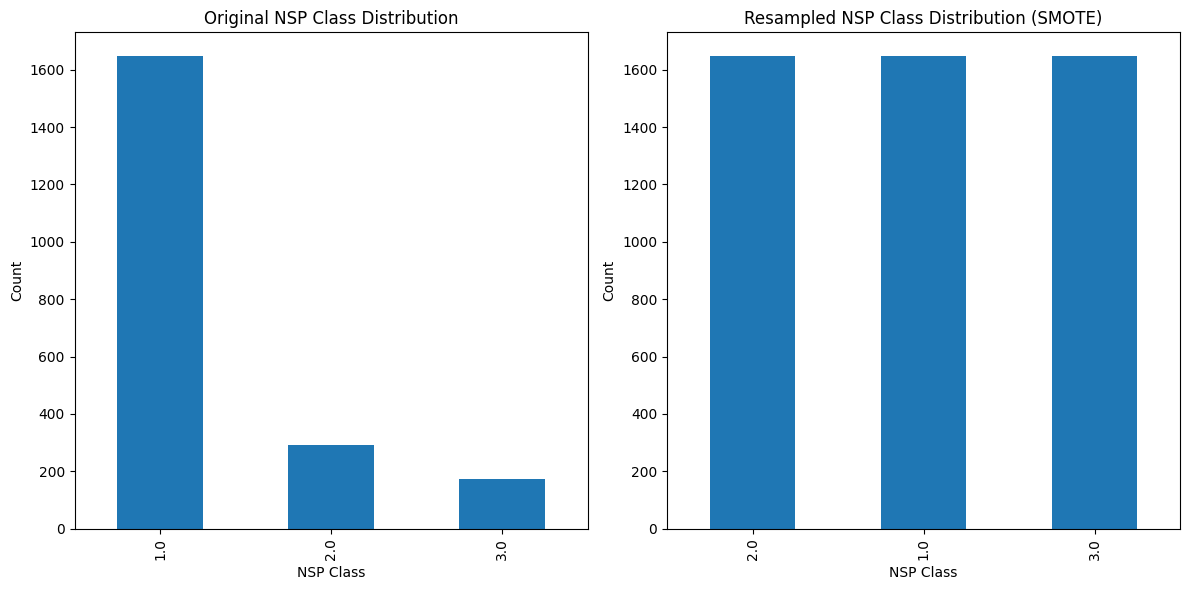

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Define your features and target variable
X = df_copy.drop(columns=['NSP'])
y = df_copy['NSP']

# Oversample using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# %% [code] {"execution":{"iopub.status.busy":"2024-11-24T18:45:42.154502Z","iopub.execute_input":"2024-11-24T18:45:42.154902Z","iopub.status.idle":"2024-11-24T18:45:42.799120Z","shell.execute_reply.started":"2024-11-24T18:45:42.154863Z","shell.execute_reply":"2024-11-24T18:45:42.797868Z"}}
import matplotlib.pyplot as plt

# Before SMOTE - Original class distribution
plt.figure(figsize=(12, 6))

# Plot original class distribution
plt.subplot(1, 2, 1)
df_copy['NSP'].value_counts().plot(kind='bar', title="Original NSP Class Distribution")
plt.xlabel("NSP Class")
plt.ylabel("Count")

# After SMOTE - Resampled class distribution
plt.subplot(1, 2, 2)
y_resampled.value_counts().plot(kind='bar', title="Resampled NSP Class Distribution (SMOTE)")
plt.xlabel("NSP Class")
plt.ylabel("Count")

# Show both plots side by side
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of outliers detected: 248


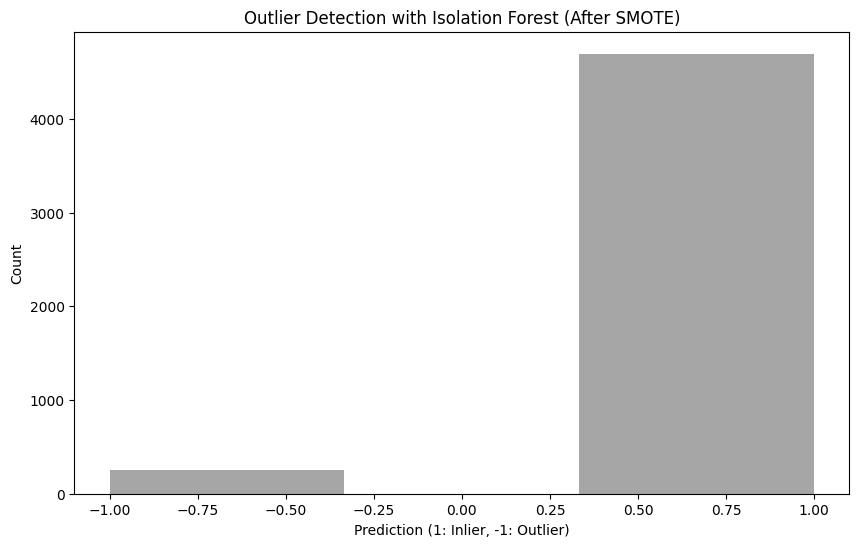

In [8]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the Isolation Forest model on the resampled data
iso_forest.fit(X_resampled)

# Predict anomalies (outliers) in the dataset
outlier_predictions = iso_forest.predict(X_resampled)

# Convert predictions: 1 means inlier, -1 means outlier
outliers = (outlier_predictions == -1)

# Add the outlier information to the resampled DataFrame
X_resampled['outlier'] = outliers

# Plot the number of outliers
outlier_count = outliers.sum()
print(f"Number of outliers detected: {outlier_count}")

# Visualize the distribution of outliers
plt.figure(figsize=(10, 6))
plt.hist(outlier_predictions, bins=3, color='gray', alpha=0.7)
plt.title("Outlier Detection with Isolation Forest (After SMOTE)")
plt.xlabel("Prediction (1: Inlier, -1: Outlier)")
plt.ylabel("Count")
plt.show()

In [9]:
X_no_outliers = X_resampled[outlier_predictions == 1]
y_no_outliers = y_resampled[outlier_predictions == 1]

# Create the cleaned DataFrame (df_Clean) by combining features and target variable
df_Clean = X_no_outliers.copy()
df_Clean['NSP'] = y_no_outliers

# Verify the new shape of the cleaned dataset
print(f"Original data shape: {X_resampled.shape}")
print(f"Cleaned data shape: {df_Clean.shape}")

# Optionally, you can also check the number of outliers removed
outliers_removed = X_resampled.shape[0] - df_Clean.shape[0]
print(f"Number of outliers removed: {outliers_removed}")


Original data shape: (4944, 35)
Cleaned data shape: (4696, 36)
Number of outliers removed: 248


In [10]:
df_copy

LBE     LB   AC   FM   UC  ASTV  MSTV  ALTV  MLTV   DL  ...    C    D  \
0     120.0  120.0  0.0  0.0  0.0  73.0   0.5  43.0   2.4  0.0  ...  0.0  0.0   
1     132.0  132.0  4.0  0.0  4.0  17.0   2.1   0.0  10.4  2.0  ...  0.0  0.0   
2     133.0  133.0  2.0  0.0  5.0  16.0   2.1   0.0  13.4  2.0  ...  0.0  0.0   
3     134.0  134.0  2.0  0.0  6.0  16.0   2.4   0.0  23.0  2.0  ...  0.0  0.0   
4     132.0  132.0  4.0  0.0  5.0  16.0   2.4   0.0  19.9  0.0  ...  0.0  0.0   
...     ...    ...  ...  ...  ...   ...   ...   ...   ...  ...  ...  ...  ...   
2121  140.0  140.0  0.0  0.0  6.0  79.0   0.2  25.0   7.2  0.0  ...  0.0  0.0   
2122  140.0  140.0  1.0  0.0  9.0  78.0   0.4  22.0   7.1  0.0  ...  0.0  0.0   
2123  140.0  140.0  1.0  0.0  7.0  79.0   0.4  20.0   6.1  0.0  ...  0.0  0.0   
2124  140.0  140.0  1.0  0.0  9.0  78.0   0.4  27.0   7.0  0.0  ...  0.0  0.0   
2125  142.0  142.0  1.0  1.0  5.0  74.0   0.4  36.0   5.0  0.0  ...  0.0  0.0   

        E   AD   DE   LD   FS  SUSP  CLASS  NSP  
0     0.0  0.0  0.0  0.0  1.0   0.0    9.0  2.0  
1     0.0  1.0  0.0  0.0  0.0   0.0    6.0  1.0  
2     0.0  1.0  0.0  0.0  0.0   0.0    6.0  1.0  
3     0.0  1.0  0.0  0.0  0.0   0.0    6.0  1.0  
4     0.0  0.0  0.0  0.0  0.0   0.0    2.0  1.0  
...   ...  ...  ...  ...  ...   ...    ...  ...  
2121  1.0  0.0  0.0  0.0  0.0   0.0    5.0  2.0  
2122  1.0  0.0  0.0  0.0  0.0   0.0    5.0  2.0  
2123  1.0  0.0  0.0  0.0  0.0   0.0    5.0  2.0  
2124  1.0  0.0  0.0  0.0  0.0   0.0    5.0  2.0  
2125  0.0  0.0  0.0  0.0  0.0   0.0    1.0  1.0  

[2114 rows x 35 columns]

In [11]:
X_Clean = df_Clean.drop(columns=['NSP'])  # Features (all columns except 'NSP')
y_Clean = df_Clean['NSP']  # Target variable (NSP)


# %% [code] {"execution":{"iopub.status.busy":"2024-11-24T18:49:16.712475Z","iopub.execute_input":"2024-11-24T18:49:16.713432Z","iopub.status.idle":"2024-11-24T18:49:16.741555Z","shell.execute_reply.started":"2024-11-24T18:49:16.713364Z","shell.execute_reply":"2024-11-24T18:49:16.740303Z"}}
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize the scaler
scaler = StandardScaler()

# Step 2: Fit and transform the features
X_Clean_scaled = scaler.fit_transform(X_Clean)


# Gradient Boosting


Training Accuracy: 94.6486%
Testing Accuracy: 95.0000%

Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.97      1.00      0.98       310
         2.0       0.90      0.97      0.93       326
         3.0       1.00      0.88      0.94       304

    accuracy                           0.95       940
   macro avg       0.95      0.95      0.95       940
weighted avg       0.95      0.95      0.95       940



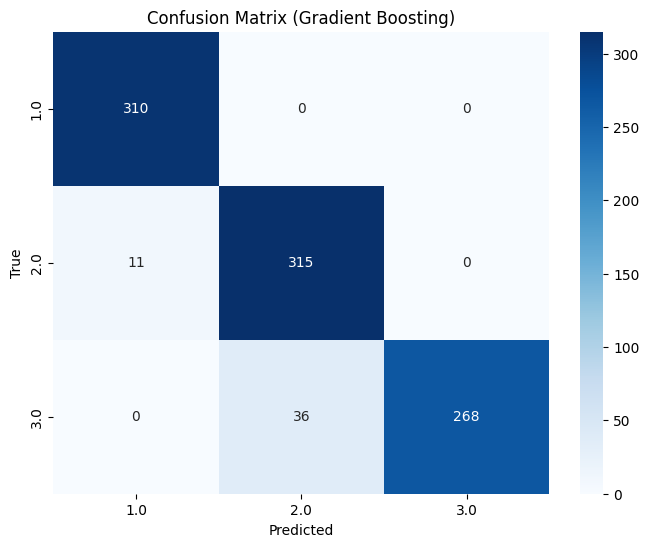

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Scale the features
scaler = StandardScaler()
X_Clean_scaled = scaler.fit_transform(X_Clean)  # Assuming X_Clean is your features

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

gb = GradientBoostingClassifier(
    n_estimators=30,        # Fewer boosting stages
    learning_rate=0.01,     # Slower learning
    max_depth=2,            # Shallower trees
    min_samples_split=50,   # Larger splits
    min_samples_leaf=25,    # Larger leaf nodes
    subsample=0.7,          # Smaller data subsets per stage
    max_features='sqrt',    # Randomly consider sqrt of features
    min_impurity_decrease=0.01,  # Higher threshold for splits
    loss='log_loss',        # Logarithmic loss
    random_state=42
)

# Fit the model to training data
gb.fit(X_train, y_train)

# Predictions
y_train_pred_gb = gb.predict(X_train)
y_test_pred_gb = gb.predict(X_test)

# Evaluate
train_accuracy_gb = accuracy_score(y_train, y_train_pred_gb)
test_accuracy_gb = accuracy_score(y_test, y_test_pred_gb)

print(f"\nTraining Accuracy: {train_accuracy_gb * 100:.4f}%")
print(f"Testing Accuracy: {test_accuracy_gb * 100:.4f}%")

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred_gb))

# Confusion Matrix
conf_matrix_gb = confusion_matrix(y_test, y_test_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_Clean), yticklabels=np.unique(y_Clean))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Gradient Boosting)')
plt.show()




ROC AUC values for each class:
Class '1.0': 0.9990
Class '2.0': 0.9919
Class '3.0': 0.9991


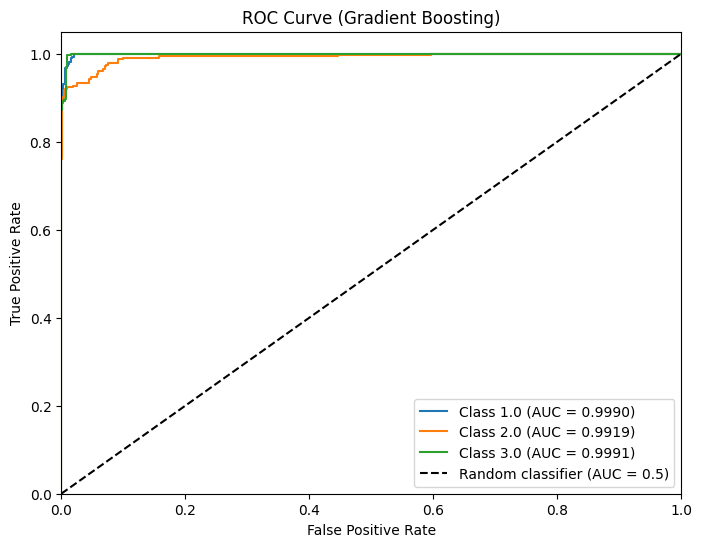


Micro-average ROC AUC: 0.9951


In [13]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Step 1: Calculate the ROC AUC score
# Binarize the labels if you have multiple classes
y_test_bin = label_binarize(y_test, classes=np.unique(y_Clean))
y_train_bin = label_binarize(y_train, classes=np.unique(y_Clean))

# Get the predicted probabilities for the test data
y_test_prob_gb = gb.predict_proba(X_test)

# For multi-class, calculate ROC AUC for each class
roc_auc_values = {}
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob_gb[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_prob_gb[:, i])
    roc_auc_values[np.unique(y_Clean)[i]] = roc_auc[i]

# Print ROC AUC values
print("\nROC AUC values for each class:")
for label, auc in roc_auc_values.items():
    print(f"Class '{label}': {auc:.4f}")

# Step 2: Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {np.unique(y_Clean)[i]} (AUC = {roc_auc[i]:.4f})')

# Plotting the diagonal (no discrimination line)
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gradient Boosting)')
plt.legend(loc="lower right")
plt.show()

# Optionally: Calculate and print overall ROC AUC for multi-class (micro-average)
roc_auc_micro = roc_auc_score(y_test_bin, y_test_prob_gb, average='micro')
print(f"\nMicro-average ROC AUC: {roc_auc_micro:.4f}")


# XGBoost


Training Accuracy: 97.9499%
Testing Accuracy: 98.0851%

Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97       310
         2.0       1.00      0.95      0.97       326
         3.0       1.00      1.00      1.00       304

    accuracy                           0.98       940
   macro avg       0.98      0.98      0.98       940
weighted avg       0.98      0.98      0.98       940



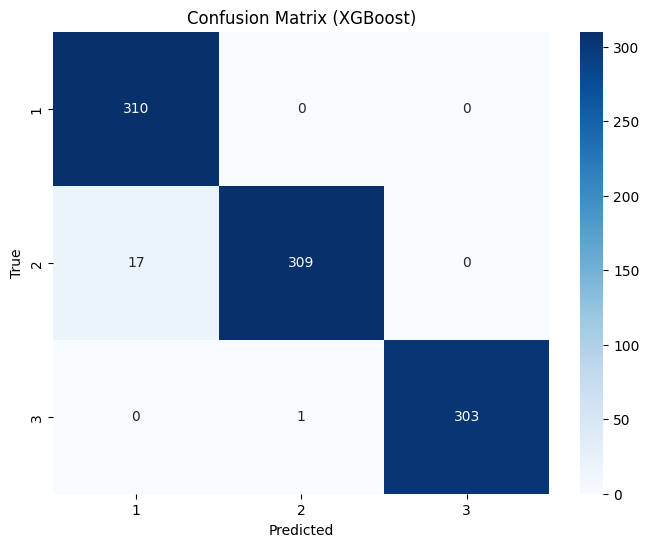

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert labels to zero-based integers
y_train_int = y_train - 1
y_test_int = y_test - 1

# Initialize XGBoost Classifier
xgb = XGBClassifier(
    n_estimators=50,             # Fewer trees
    learning_rate=0.01,          # Slower learning rate
    max_depth=3,                 # Shallower trees
    min_child_weight=10,         # Larger minimum sum of instance weight
    subsample=0.7,               # Smaller data subset per tree
    colsample_bytree=0.7,        # Smaller feature subset per tree
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=1.0,              # L2 regularization
    random_state=42,
    use_label_encoder=False,     # Avoid label encoding warning
    objective='multi:softmax',   # Multi-class classification
    num_class=3                  # Number of unique classes (0, 1, 2)
)

# Fit the model
xgb.fit(X_train, y_train_int)

# Predictions (convert back to one-based labels for interpretation)
y_train_pred_xgb = xgb.predict(X_train) + 1
y_test_pred_xgb = xgb.predict(X_test) + 1

# Evaluate
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"\nTraining Accuracy: {train_accuracy_xgb * 100:.4f}%")
print(f"Testing Accuracy: {test_accuracy_xgb * 100:.4f}%")

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_test_pred_xgb))

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (XGBoost)')
plt.show()



ROC AUC values for each class:
Class 1: 0.9998
Class 2: 0.9996
Class 3: 1.0000


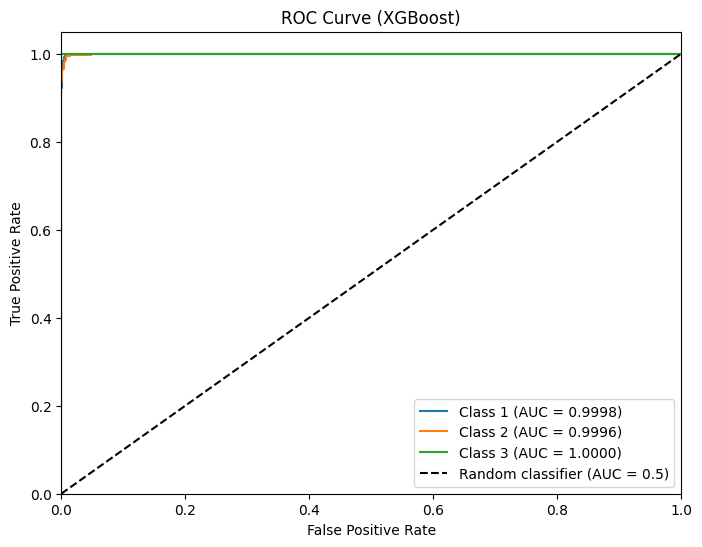


Micro-average ROC AUC: 0.9997


In [16]:
# ROC AUC Calculation
# Binarize the labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_train_bin = label_binarize(y_train, classes=[1, 2, 3])

# Get the predicted probabilities for the test data
y_test_prob_xgb = xgb.predict_proba(X_test)

# For multi-class, calculate ROC AUC for each class
roc_auc_values = {}
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob_xgb[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_prob_xgb[:, i])
    roc_auc_values[i + 1] = roc_auc[i]

# Print ROC AUC values
print("\nROC AUC values for each class:")
for label, auc in roc_auc_values.items():
    print(f"Class {label}: {auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i + 1} (AUC = {roc_auc[i]:.4f})')

# Plot the diagonal line (no discrimination line)
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend(loc="lower right")
plt.show()

# Optionally: Calculate and print overall ROC AUC for multi-class (micro-average)
roc_auc_micro = roc_auc_score(y_test_bin, y_test_prob_xgb, average='micro')
print(f"\nMicro-average ROC AUC: {roc_auc_micro:.4f}")

# LightGBM

In [17]:
!pip install --upgrade lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.2.0
    Uninstalling lightgbm-4.2.0:
      Successfully uninstalled lightgbm-4.2.0


In [18]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

# Convert the labels to zero-indexed (if they start from 1)
y_train_zero_indexed = y_train - 1
y_test_zero_indexed = y_test - 1

# Set up the parameters for LightGBM with more regularization and tuning
params = {
    'objective': 'multiclass',        # Multi-class classification
    'num_class': 3,                   # Number of classes
    'metric': 'multi_logloss',        # Metric for multi-class logloss
    'num_leaves': 20,                 # Reduce number of leaves to prevent overfitting
    'max_depth': 4,                   # Reduce tree depth to prevent overfitting
    'min_data_in_leaf': 100,          # Increase the minimum number of data in each leaf
    'learning_rate': 0.01,            # Use a smaller learning rate to prevent overfitting
    'boosting_type': 'gbdt',          # Gradient boosting decision tree
    'lambda_l1': 0.5,                 # Increase L1 regularization (for sparsity)
    'lambda_l2': 0.5,                 # Increase L2 regularization (for weight decay)
    'verbosity': -1,                  # Suppress warnings and logs
    'bagging_fraction': 0.8,          # Use 80% of the data for each tree
    'feature_fraction': 0.8,          # Use 80% of features randomly in each iteration
    'bagging_freq': 5,                # Bagging frequency (ensures randomness)
}

# Prepare the dataset for LightGBM (train_data and test_data are assumed to be predefined)
train_data = lgb.Dataset(X_train, label=y_train_zero_indexed, free_raw_data=False)  # Set free_raw_data=False
test_data = lgb.Dataset(X_test, label=y_test_zero_indexed, reference=train_data, free_raw_data=False)  # Set free_raw_data=False

# Define the callback to track training progress
def early_stopping_callback(iteration=20, threshold=0.01):
    best_score = float('inf')
    model = None
    for i in range(iteration):  # Maximum boosting rounds
        # Train the model for one iteration at a time
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, test_data],  # Pass both training and validation sets
            num_boost_round=1,                   # Train for just 1 round each time
            init_model=model if i > 0 else None  # Initialize the model after the first iteration
        )
        
        # Check the validation score (multi_logloss)
        val_score = model.best_score['valid_1']['multi_logloss']
        print(f"Iteration {i+1}: Validation Logloss: {val_score}")
        
        # Stop if there is no improvement
        if val_score < best_score - threshold:
            best_score = val_score
        else:
            print(f"Early stopping at iteration {i+1}")
            break
    
    return model

# Call early stopping function and train the model
model = early_stopping_callback()

# Predictions (convert back to one-based labels for interpretation)
y_train_pred_lgb = model.predict(X_train).argmax(axis=1) + 1  # Add 1 to make it one-based
y_test_pred_lgb = model.predict(X_test).argmax(axis=1) + 1  # Add 1 to make it one-based

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_lgb) * 100
test_accuracy = accuracy_score(y_test, y_test_pred_lgb) * 100

# Display training and testing accuracy
print(f"Training Accuracy: {train_accuracy:.4f}%")
print(f"Testing Accuracy: {test_accuracy:.4f}%")

# Classification Report (Test Data)
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_lgb))


Iteration 1: Validation Logloss: 1.0796896314347832
Iteration 2: Validation Logloss: 1.0616460578984999
Iteration 3: Validation Logloss: 1.0440299263612023
Iteration 4: Validation Logloss: 1.0268258169594031
Iteration 5: Validation Logloss: 1.010019146228217
Iteration 6: Validation Logloss: 0.9935961065096064
Iteration 7: Validation Logloss: 0.9775436090506907
Iteration 8: Validation Logloss: 0.9616695404692385
Iteration 9: Validation Logloss: 0.94598796564352
Iteration 10: Validation Logloss: 0.930652257373029
Iteration 11: Validation Logloss: 0.9156512894397113
Iteration 12: Validation Logloss: 0.9008070314637959
Iteration 13: Validation Logloss: 0.8864451073375774
Iteration 14: Validation Logloss: 0.8723907886477764
Iteration 15: Validation Logloss: 0.8584697125345838
Iteration 16: Validation Logloss: 0.8449973542467208
Iteration 17: Validation Logloss: 0.8316477071912525
Iteration 18: Validation Logloss: 0.8187139841615039
Iteration 19: Validation Logloss: 0.8060514172260893
Iterat


ROC AUC values for each class:
Class 1: 0.9977
Class 2: 0.9958
Class 3: 1.0000


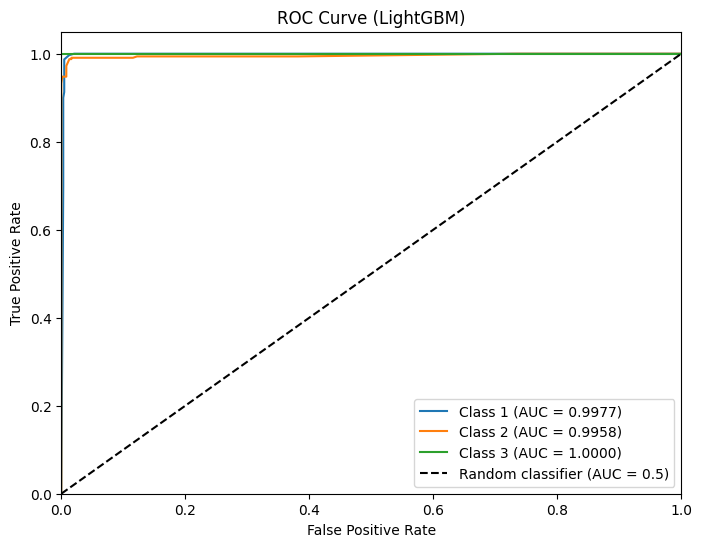


Micro-average ROC AUC: 0.9988


In [19]:
# ROC AUC Calculation
# Binarize the labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])
y_train_bin = label_binarize(y_train, classes=[1, 2, 3])

# Get the predicted probabilities for the test data
y_test_prob_lgb = model.predict(X_test)

# For multi-class, calculate ROC AUC for each class
roc_auc_values = {}
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob_lgb[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_prob_lgb[:, i])
    roc_auc_values[i + 1] = roc_auc[i]

# Print ROC AUC values
print("\nROC AUC values for each class:")
for label, auc in roc_auc_values.items():
    print(f"Class {label}: {auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i + 1} (AUC = {roc_auc[i]:.4f})')

# Plot the diagonal line (no discrimination line)
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (LightGBM)')
plt.legend(loc="lower right")
plt.show()

# Optionally: Calculate and print overall ROC AUC for multi-class (micro-average)
roc_auc_micro = roc_auc_score(y_test_bin, y_test_prob_lgb, average='micro')
print(f"\nMicro-average ROC AUC: {roc_auc_micro:.4f}")

# 

# CatBoost

In [20]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Further adjusted model parameters to combat overfitting
model_catboost = CatBoostClassifier(
    objective='MultiClass',
    iterations=400,  # Reduced iterations further
    depth=3,  # Further reduced depth to avoid overfitting
    learning_rate=0.005,  # Reduced learning rate to allow more gradual learning
    l2_leaf_reg=40,  # Increased L2 regularization to reduce complexity
    bagging_temperature=1.2,  # Increased bagging temperature for more randomness
    random_strength=0.7,  # Increased random strength to add more variability
    bootstrap_type='Bayesian',  # Keep Bayesian bootstrap
    colsample_bylevel=0.6,  # Reduced column sampling for added randomness
    early_stopping_rounds=30,  # Aggressive early stopping
    metric_period=50,
    cat_features=[],
    verbose=100
)

# Train the model
model_catboost.fit(X_train, y_train_zero_indexed, eval_set=(X_test, y_test_zero_indexed))

# Predictions (convert back to one-based labels for interpretation)
y_train_pred_catboost = model_catboost.predict(X_train) + 1  # Add 1 to make it one-based
y_test_pred_catboost = model_catboost.predict(X_test) + 1  # Add 1 to make it one-based

# Calculate training and testing accuracy
train_accuracy_catboost = accuracy_score(y_train, y_train_pred_catboost) * 100
test_accuracy_catboost = accuracy_score(y_test, y_test_pred_catboost) * 100

# Display training and testing accuracy
print(f"Training Accuracy: {train_accuracy_catboost:.4f}%")
print(f"Testing Accuracy: {test_accuracy_catboost:.4f}%")

# Classification Report (Test Data)
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_catboost))



0:	learn: 1.0919862	test: 1.0919971	best: 1.0919971 (0)	total: 59.9ms	remaining: 23.9s
100:	learn: 0.6411871	test: 0.6390478	best: 0.6390478 (100)	total: 292ms	remaining: 864ms
200:	learn: 0.4264641	test: 0.4217573	best: 0.4217573 (200)	total: 498ms	remaining: 493ms
300:	learn: 0.3086028	test: 0.3012195	best: 0.3012195 (300)	total: 704ms	remaining: 232ms
399:	learn: 0.2366234	test: 0.2276416	best: 0.2276416 (399)	total: 908ms	remaining: 0us

bestTest = 0.2276415851
bestIteration = 399

Training Accuracy: 97.0447%
Testing Accuracy: 97.6596%
Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.94      1.00      0.97       310
         2.0       0.99      0.94      0.97       326
         3.0       1.00      0.99      1.00       304

    accuracy                           0.98       940
   macro avg       0.98      0.98      0.98       940
weighted avg       0.98      0.98      0.98       940

[CV] END colsample_bytree=1.0, gamma=0

ROC AUC Score: 0.9993


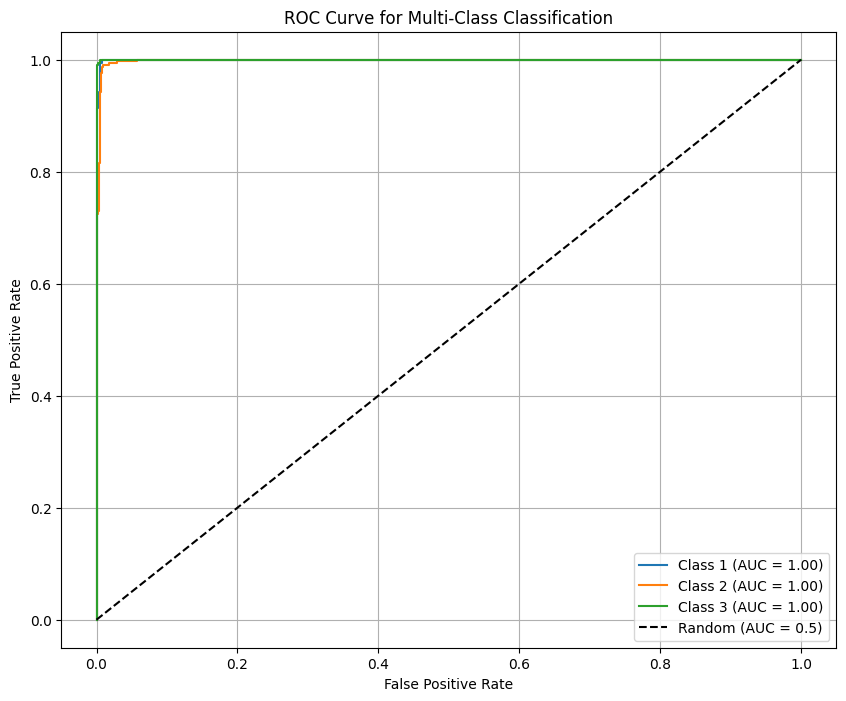

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# ROC AUC (for multi-class classification)
# Convert labels to binary format for multi-class AUC calculation
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train_zero_indexed)
y_test_bin = lb.transform(y_test_zero_indexed)

# Predict probabilities
y_test_prob_catboost = model_catboost.predict_proba(X_test)

# Calculate ROC AUC score (macro averaging)
roc_auc = roc_auc_score(y_test_bin, y_test_prob_catboost, average='macro', multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

# Calculate ROC curve for each class
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_test_prob_catboost.ravel())
roc_auc_per_class = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob_catboost[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc_class:.2f})')

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# Customize plot
plt.title('ROC Curve for Multi-Class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# NaiveBayes

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# Initialize Gaussian Naive Bayes model
model_nb = GaussianNB()

# Train the Naive Bayes model
model_nb.fit(X_train, y_train)

# Step 3: Make Predictions
y_train_pred_nb = model_nb.predict(X_train)  # Predictions for training set
y_test_pred_nb = model_nb.predict(X_test)  # Predictions for testing set

# Step 4: Evaluate the model

# Calculate training and testing accuracy
train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb) * 100
test_accuracy_nb = accuracy_score(y_test, y_test_pred_nb) * 100

# Display training and testing accuracy
print(f"Training Accuracy: {train_accuracy_nb:.4f}%")
print(f"Testing Accuracy: {test_accuracy_nb:.4f}%")

# Classification Report (Test Data)
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_nb))


Training Accuracy: 97.5772%
Testing Accuracy: 99.0426%
Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.99      0.98      0.99       310
         2.0       0.98      0.99      0.99       326
         3.0       1.00      1.00      1.00       304

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940



In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for Gaussian Naive Bayes
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Regularization hyperparameter
}

# Initialize the model
nb_model = GaussianNB()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best Hyperparameters: {best_params}")

# Predictions with the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

# Display training and testing accuracy
print(f"Training Accuracy: {train_accuracy:.4f}%")
print(f"Testing Accuracy: {test_accuracy:.4f}%")

# Classification report on the test set
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'var_smoothing': 1e-05}
Training Accuracy: 98.0298%
Testing Accuracy: 99.1489%
Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.99       310
         2.0       0.99      0.98      0.99       326
         3.0       1.00      1.00      1.00       304

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940



In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution for Gaussian Naive Bayes
param_dist = {
    'var_smoothing': uniform(1e-9, 1e-5)  # Uniform distribution over a range of values
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_

# Print the best hyperparameters
print(f"Best Hyperparameters (Random Search): {best_params_random}")

# Predictions with the best model from RandomizedSearchCV
y_train_pred_random = best_model_random.predict(X_train)
y_test_pred_random = best_model_random.predict(X_test)

# Calculate training and testing accuracy
train_accuracy_random = accuracy_score(y_train, y_train_pred_random) * 100
test_accuracy_random = accuracy_score(y_test, y_test_pred_random) * 100

# Display training and testing accuracy
print(f"Training Accuracy (Random Search): {train_accuracy_random:.4f}%")
print(f"Testing Accuracy (Random Search): {test_accuracy_random:.4f}%")

# Classification report on the test set
print("Classification Report (Test Data - Random Search):")
print(classification_report(y_test, y_test_pred_random))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters (Random Search): {'var_smoothing': 3.746401188473625e-06}
Training Accuracy (Random Search): 98.0564%
Testing Accuracy (Random Search): 99.1489%
Classification Report (Test Data - Random Search):
              precision    recall  f1-score   support

         1.0       0.98      0.99      0.99       310
         2.0       0.99      0.98      0.99       326
         3.0       1.00      1.00      1.00       304

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940



ROC AUC Score (Random Search): 0.9998


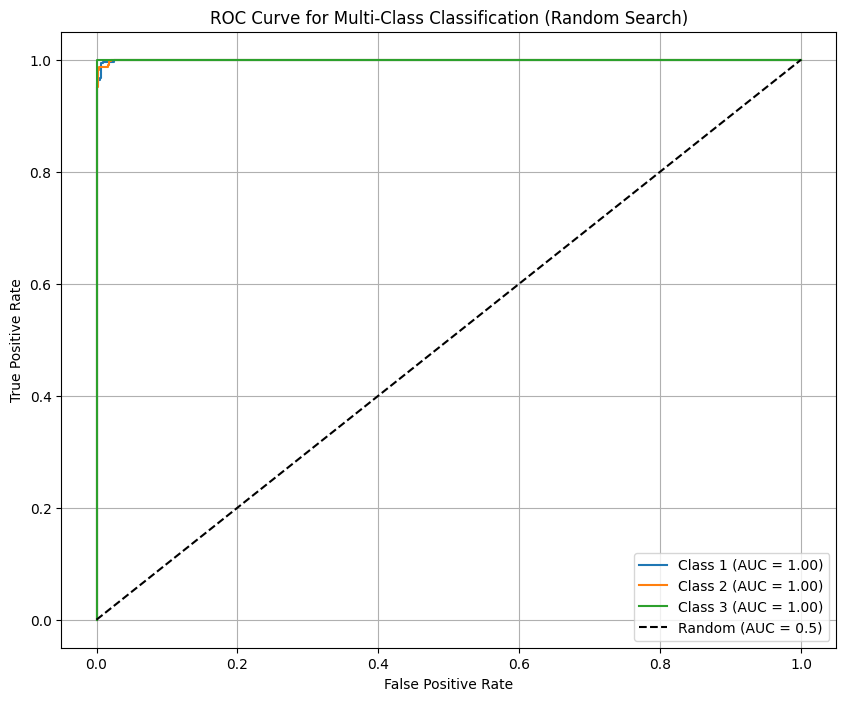

In [28]:
# ROC AUC (for multi-class classification)
# Convert labels to binary format for multi-class AUC calculation
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

# Predict probabilities
y_test_prob_random = best_model_random.predict_proba(X_test)

# Calculate ROC AUC score (macro averaging)
roc_auc = roc_auc_score(y_test_bin, y_test_prob_random, average='macro', multi_class='ovr')
print(f"ROC AUC Score (Random Search): {roc_auc:.4f}")

# Calculate ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob_random[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc_class:.2f})')

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# Customize plot
plt.title('ROC Curve for Multi-Class Classification (Random Search)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 

# AdaBoost

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Use 'estimator' instead of 'base_estimator'
estimator = DecisionTreeClassifier(max_depth=1)  # Weak learner
ada_boost = AdaBoostClassifier(estimator=estimator)  # 'base_estimator' changed to 'estimator'

# Now proceed with GridSearchCV as you did before

# Define the parameter grid for AdaBoost
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of estimators (trees)
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Learning rate for weighting the weak learners
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=ada_boost, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best Hyperparameters: {best_params}")

# Predictions with the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train, y_train_pred) * 100
test_accuracy = accuracy_score(y_test, y_test_pred) * 100

# Display training and testing accuracy
print(f"Training Accuracy: {train_accuracy:.4f}%")
print(f"Testing Accuracy: {test_accuracy:.4f}%")

# Classification report on the test set
print("Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 150}
Training Accuracy: 96.6986%
Testing Accuracy: 97.1277%
Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.93      1.00      0.96       310
         2.0       0.99      0.93      0.96       326
         3.0       1.00      0.99      0.99       304

    accuracy                           0.97       940
   macro avg       0.97      0.97      0.97       940
weighted avg       0.97      0.97      0.97       940



ROC AUC Score (AdaBoost): 0.9975


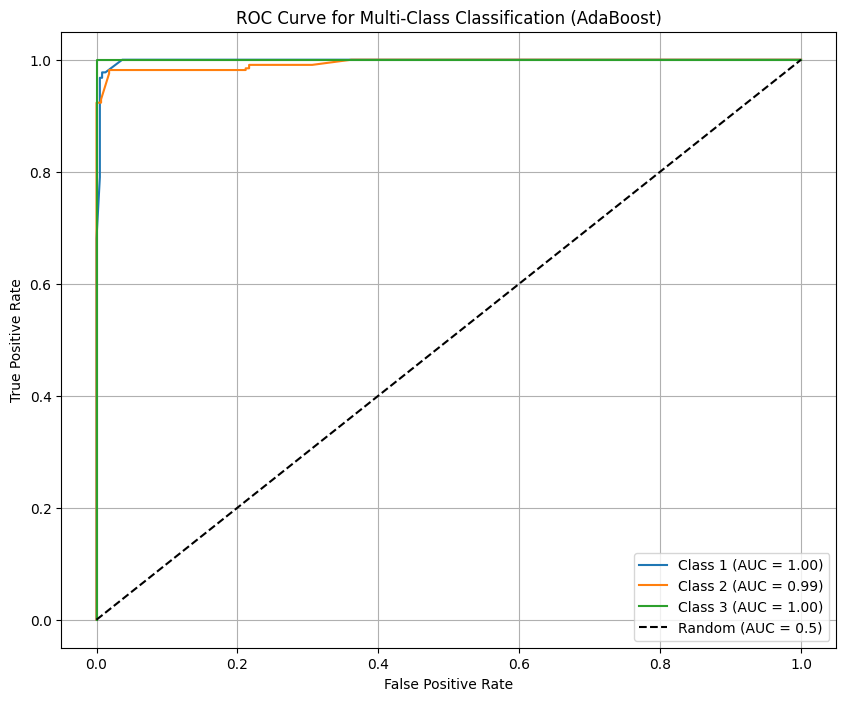

In [31]:
# ROC AUC (for multi-class classification)
# Convert labels to binary format for multi-class AUC calculation
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

# Predict probabilities
y_test_prob_ada = best_model.predict_proba(X_test)

# Calculate ROC AUC score (macro averaging)
roc_auc = roc_auc_score(y_test_bin, y_test_prob_ada, average='macro', multi_class='ovr')
print(f"ROC AUC Score (AdaBoost): {roc_auc:.4f}")

# Calculate ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob_ada[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc_class:.2f})')

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# Customize plot
plt.title('ROC Curve for Multi-Class Classification (AdaBoost)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Stacking classifier

In [32]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Your existing code for AdaBoost and StackingClassifier follows


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split the data into training and testing sets (replace this with your custom dataset)
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Stacking Classifier
# =======================
# Define base learners for stacking with more reduced complexity
base_learners = [
    ('decision_tree', DecisionTreeClassifier(max_depth=2, min_samples_split=15, min_samples_leaf=8, random_state=42)),  # Reduced depth and increased min samples
    ('svc', SVC(probability=True, C=0.01, kernel='linear', random_state=42)),  # Increased regularization (C=0.01)
    ('knn', KNeighborsClassifier(n_neighbors=5)),  # Keep KNeighborsClassifier simple
    ('xgb', GradientBoostingClassifier(n_estimators=20, max_depth=2, learning_rate=0.02, random_state=42))  # Reduced n_estimators, max_depth and learning rate
]

# Define the meta-classifier (RandomForest in this case)
meta_learner = RandomForestClassifier(n_estimators=25, max_depth=4, min_samples_split=15, min_samples_leaf=8, random_state=42)  # Reduced n_estimators and added more constraints

# Create the Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# Fit the Stacking Classifier model
stacking_clf.fit(X_train, y_train)

# Predictions with Stacking model
y_train_pred_stack = stacking_clf.predict(X_train)
y_test_pred_stack = stacking_clf.predict(X_test)

# Calculate training and testing accuracy for Stacking Classifier
train_accuracy_stack = accuracy_score(y_train, y_train_pred_stack) * 100
test_accuracy_stack = accuracy_score(y_test, y_test_pred_stack) * 100

# Display training and testing accuracy for Stacking Classifier
print(f"Stacking Training Accuracy: {train_accuracy_stack:.4f}%")
print(f"Stacking Testing Accuracy: {test_accuracy_stack:.4f}%")

# Classification report on the test set for the Stacking Classifier
print("Stacking Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_stack))

# Print confusion matrix for the Stacking model
print("Confusion Matrix (Test Data) for Stacking Classifier:")
print(confusion_matrix(y_test, y_test_pred_stack))


Stacking Training Accuracy: 99.7870%
Stacking Testing Accuracy: 99.8936%
Stacking Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       310
         2.0       1.00      1.00      1.00       326
         3.0       1.00      1.00      1.00       304

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

Confusion Matrix (Test Data) for Stacking Classifier:
[[309   1   0]
 [  0 326   0]
 [  0   0 304]]


ROC AUC Score (Stacking Classifier): 1.0000


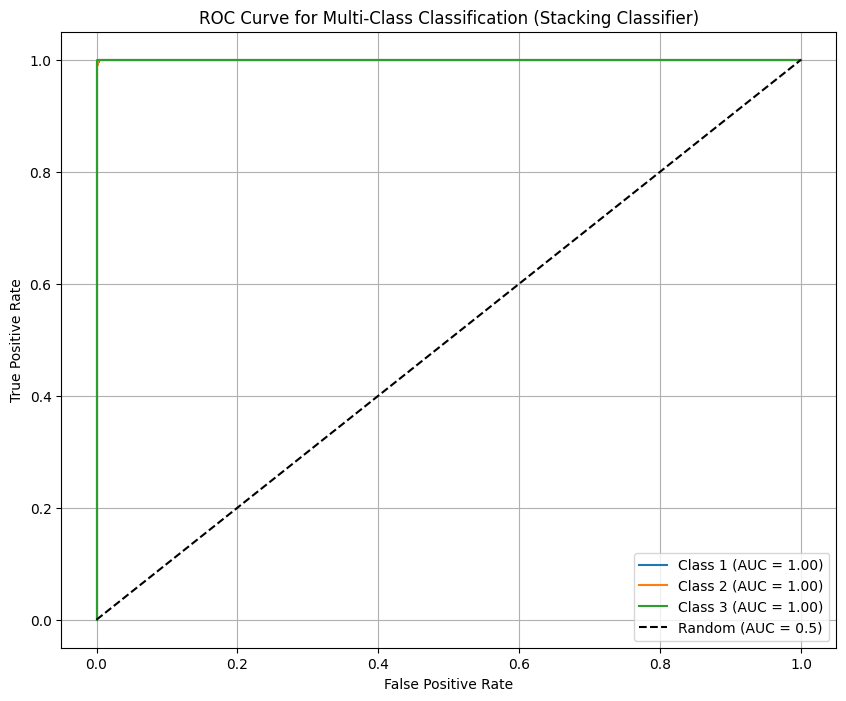

In [34]:
# ROC AUC (for multi-class classification)
# Convert labels to binary format for multi-class AUC calculation
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

# Predict probabilities
y_test_prob_stack = stacking_clf.predict_proba(X_test)

# Calculate ROC AUC score (macro averaging)
roc_auc = roc_auc_score(y_test_bin, y_test_prob_stack, average='macro', multi_class='ovr')
print(f"ROC AUC Score (Stacking Classifier): {roc_auc:.4f}")

# Calculate ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob_stack[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc_class:.2f})')

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# Customize plot
plt.title('ROC Curve for Multi-Class Classification (Stacking Classifier)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Bagging Classifier

In [35]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# =======================
# Bagging Classifier with more regularization
# =======================

# Use Decision Tree as base model for Bagging with further reduced depth and additional constraints
base_estimator = DecisionTreeClassifier(
    max_depth=6,              # Further reduce max depth to avoid overfitting
    min_samples_split=20,     # Increase minimum samples for splitting to avoid overly specific trees
    min_samples_leaf=10,      # Increase minimum samples for leaves to prevent small splits
    max_features=0.4,         # Reduce the number of features used in each tree (40% of total features)
    random_state=42           # Ensure reproducibility for the base estimator
)

bagging_clf = BaggingClassifier(
    base_estimator=base_estimator,  # Decision Tree with more constraints
    n_estimators=40,  # Reduce the number of base estimators to 40
    max_samples=0.6,  # Use 60% of the training data for each base model
    max_features=0.6,  # Use 60% of the features for each base model
    random_state=42,   # Random state for the BaggingClassifier
    n_jobs=-1          # Use all available cores for parallel computation
)

# Train the Bagging Classifier
bagging_clf.fit(X_train, y_train)

# Predictions with Bagging Classifier
y_train_pred_bagging = bagging_clf.predict(X_train)
y_test_pred_bagging = bagging_clf.predict(X_test)

# Calculate training and testing accuracy for Bagging Classifier
train_accuracy_bagging = accuracy_score(y_train, y_train_pred_bagging) * 100
test_accuracy_bagging = accuracy_score(y_test, y_test_pred_bagging) * 100

# Display training and testing accuracy for Bagging Classifier
print(f"Bagging Training Accuracy: {train_accuracy_bagging:.4f}%")
print(f"Bagging Testing Accuracy: {test_accuracy_bagging:.4f}%")

# Classification report on the test set for Bagging Classifier
print("Bagging Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_bagging))

# Print confusion matrix for the Bagging model
print("Confusion Matrix (Test Data) for Bagging Classifier:")
print(confusion_matrix(y_test, y_test_pred_bagging))


Bagging Training Accuracy: 98.9084%
Bagging Testing Accuracy: 98.9362%
Bagging Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99       310
         2.0       0.98      0.98      0.98       326
         3.0       1.00      0.99      0.99       304

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940

Confusion Matrix (Test Data) for Bagging Classifier:
[[309   1   0]
 [  5 321   0]
 [  0   4 300]]


ROC AUC Score (Bagging Classifier): 0.9998


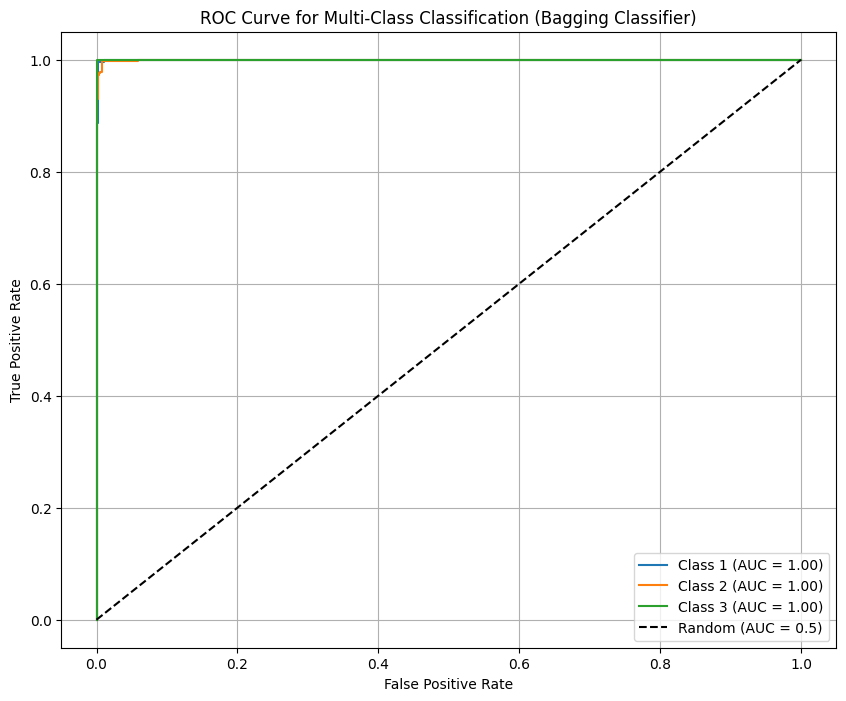

In [37]:
# ROC AUC (for multi-class classification)
# Convert labels to binary format for multi-class AUC calculation
lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

# Predict probabilities
y_test_prob_bagging = bagging_clf.predict_proba(X_test)

# Calculate ROC AUC score (macro averaging)
roc_auc = roc_auc_score(y_test_bin, y_test_prob_bagging, average='macro', multi_class='ovr')
print(f"ROC AUC Score (Bagging Classifier): {roc_auc:.4f}")

# Calculate ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob_bagging[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc_class:.2f})')

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# Customize plot
plt.title('ROC Curve for Multi-Class Classification (Bagging Classifier)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# =======================
# K-Nearest Neighbors Classifier (KNN)
# =======================

# Create the KNN model
knn_clf = KNeighborsClassifier(
    n_neighbors=5,  # Number of neighbors to consider
    weights='uniform',  # Use uniform weights (you could also use 'distance' for distance-based weighting)
    algorithm='auto',  # Auto, BallTree, KDTree, or Brute-force (automatically selects the best)
    metric='minkowski',  # Minkowski distance metric (default, which is equivalent to Euclidean distance)
    n_jobs=-1  # Use all available cores for parallel computation
)

# Train the KNN Classifier
knn_clf.fit(X_train, y_train)

# Predictions with KNN Classifier
y_train_pred_knn = knn_clf.predict(X_train)
y_test_pred_knn = knn_clf.predict(X_test)

# Calculate training and testing accuracy for KNN Classifier
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn) * 100
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn) * 100

# Display training and testing accuracy for KNN Classifier
print(f"KNN Training Accuracy: {train_accuracy_knn:.4f}%")
print(f"KNN Testing Accuracy: {test_accuracy_knn:.4f}%")

# Classification report on the test set for KNN Classifier
print("KNN Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_knn))

# Print confusion matrix for the KNN model
print("Confusion Matrix (Test Data) for KNN Classifier:")
print(confusion_matrix(y_test, y_test_pred_knn))


KNN Training Accuracy: 99.7338%
KNN Testing Accuracy: 99.7872%
KNN Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       1.00      0.99      1.00       310
         2.0       0.99      1.00      1.00       326
         3.0       1.00      1.00      1.00       304

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

Confusion Matrix (Test Data) for KNN Classifier:
[[308   2   0]
 [  0 326   0]
 [  0   0 304]]


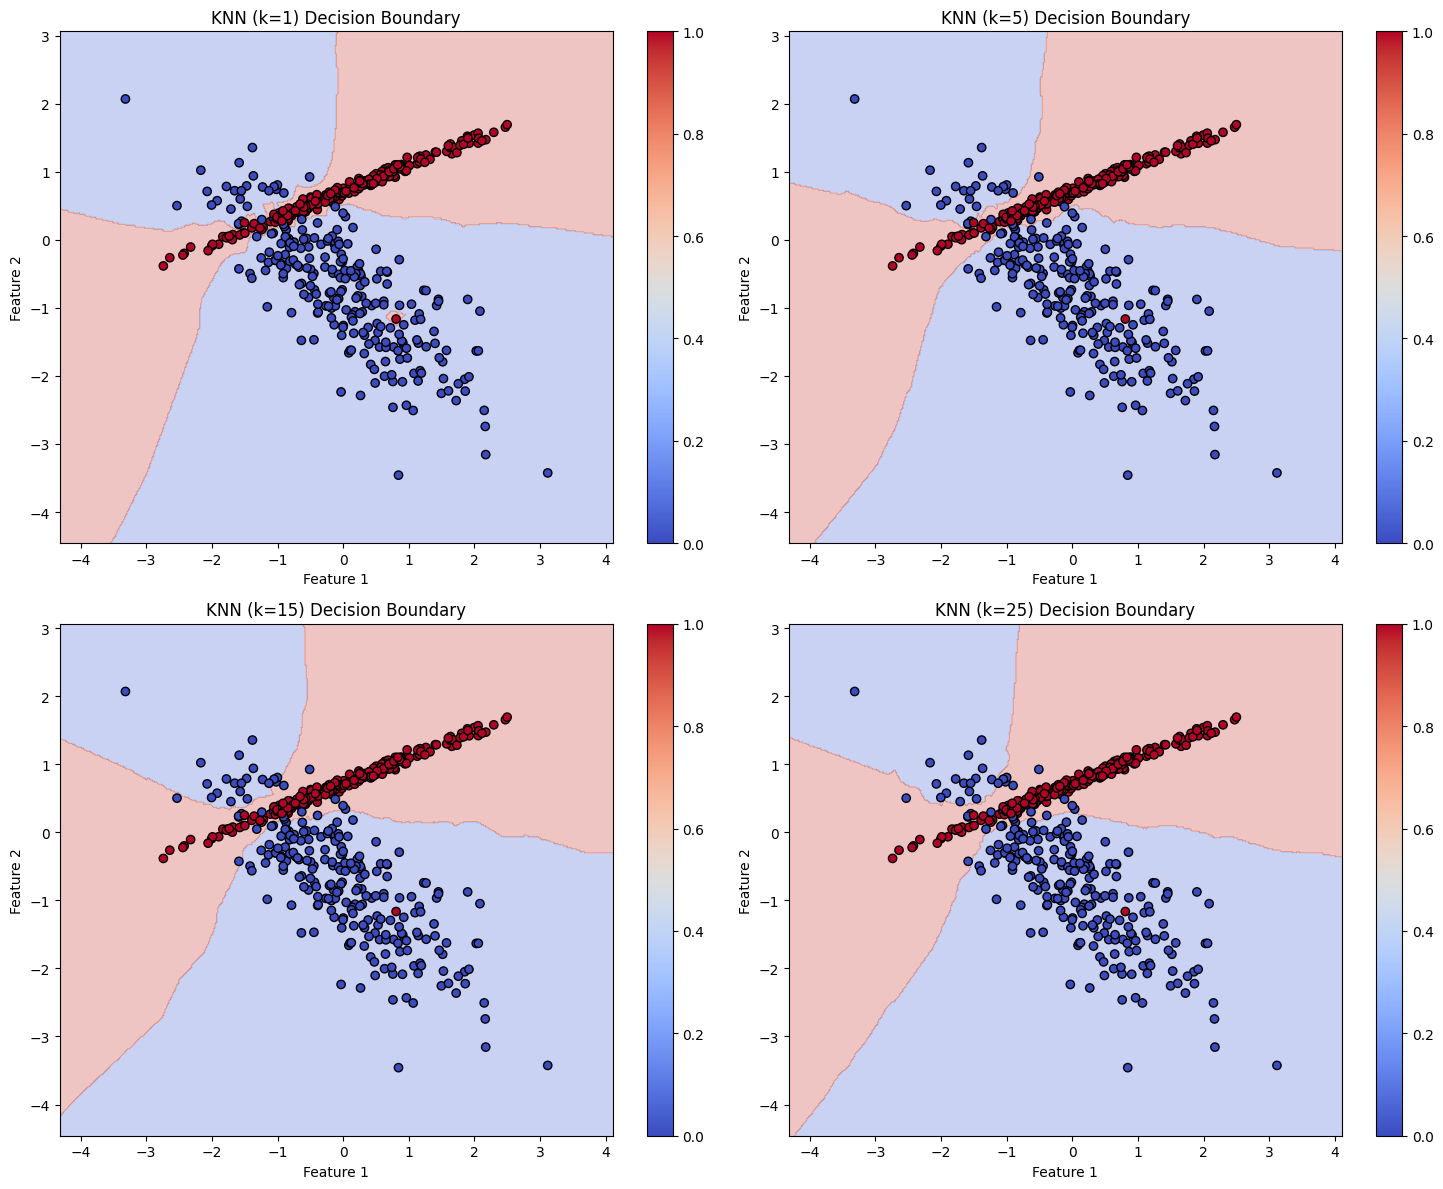

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# =======================
# Create a synthetic 2D dataset for visualization
# =======================
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# =======================
# KNN Visualization with Different k Values
# =======================
k_values = [1, 5, 15, 25]
plt.figure(figsize=(15, 12))

# Create subplots for different k values
for i, k in enumerate(k_values):
    plt.subplot(2, 2, i + 1)
    
    # Train KNN classifier with the current k value
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_scaled, y)
    
    # Create a mesh grid for plotting decision boundaries
    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Predict class for every point in the mesh grid
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    
    # Plot the data points
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title(f"KNN (k={k}) Decision Boundary")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Add a color bar
    plt.colorbar(scatter)

# Show all the subplots
plt.tight_layout()
plt.show()


KNN Training Accuracy: 99.7338%
KNN Testing Accuracy: 99.7872%
KNN Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       1.00      0.99      1.00       310
         2.0       0.99      1.00      1.00       326
         3.0       1.00      1.00      1.00       304

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

Confusion Matrix (Test Data) for KNN Classifier:
[[308   2   0]
 [  0 326   0]
 [  0   0 304]]
Multi-class ROC AUC Score: 0.9992
Class 1.0 ROC AUC: 0.9984
Class 2.0 ROC AUC: 0.9992
Class 3.0 ROC AUC: 1.0000


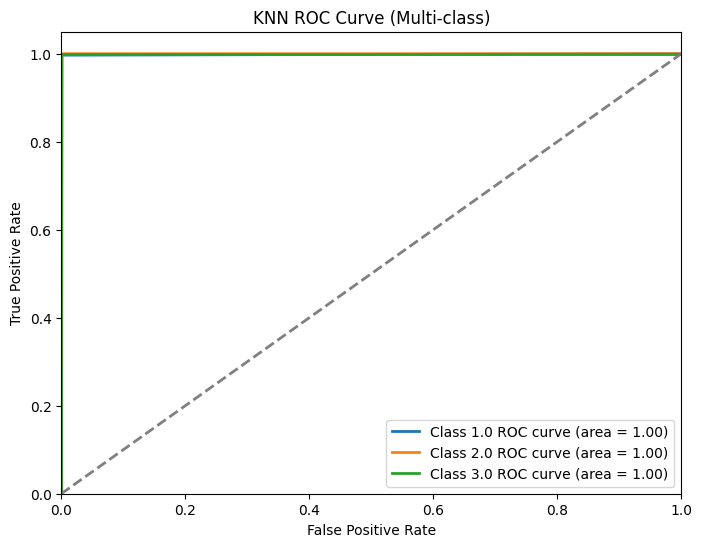

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# =======================
# K-Nearest Neighbors Classifier (KNN)
# =======================

# Create the KNN model
knn_clf = KNeighborsClassifier(
    n_neighbors=5,  # Number of neighbors to consider
    weights='uniform',  # Use uniform weights (you could also use 'distance' for distance-based weighting)
    algorithm='auto',  # Auto, BallTree, KDTree, or Brute-force (automatically selects the best)
    metric='minkowski',  # Minkowski distance metric (default, which is equivalent to Euclidean distance)
    n_jobs=-1  # Use all available cores for parallel computation
)

# Train the KNN Classifier
knn_clf.fit(X_train, y_train)

# Predictions with KNN Classifier
y_train_pred_knn = knn_clf.predict(X_train)
y_test_pred_knn = knn_clf.predict(X_test)

# Calculate training and testing accuracy for KNN Classifier
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn) * 100
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn) * 100

# Display training and testing accuracy for KNN Classifier
print(f"KNN Training Accuracy: {train_accuracy_knn:.4f}%")
print(f"KNN Testing Accuracy: {test_accuracy_knn:.4f}%")

# Classification report on the test set for KNN Classifier
print("KNN Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_knn))

# Print confusion matrix for the KNN model
print("Confusion Matrix (Test Data) for KNN Classifier:")
print(confusion_matrix(y_test, y_test_pred_knn))

# =======================
# ROC AUC for KNN Classifier
# =======================

# Check if it's a binary classification problem
if len(set(y_test)) == 2:
    # Binary classification
    y_test_bin = label_binarize(y_test, classes=[0, 1])  # Ensure binary labels
    y_score_knn = knn_clf.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
    
    # Calculate ROC AUC score
    roc_auc_binary = roc_auc_score(y_test_bin, y_score_knn)
    print(f"Binary Class ROC AUC Score: {roc_auc_binary:.4f}")

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_score_knn)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_binary:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN ROC Curve (Binary)')
    plt.legend(loc='lower right')
    plt.show()

else:
    # Multi-class classification: Dynamically set the classes
    unique_classes = sorted(set(y_test))  # Get the unique classes from y_test
    y_test_bin = label_binarize(y_test, classes=unique_classes)  # Binarize the labels
    y_score_knn = knn_clf.predict_proba(X_test)  # Get the probabilities for all classes
    
    # Calculate ROC AUC score for multi-class
    roc_auc_multi = roc_auc_score(y_test_bin, y_score_knn, average='macro', multi_class='ovr')
    print(f"Multi-class ROC AUC Score: {roc_auc_multi:.4f}")

    # Compute ROC curve for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(y_test_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_knn[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Print AUC value for each class
        print(f"Class {unique_classes[i]} ROC AUC: {roc_auc[i]:.4f}")

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(y_test_bin.shape[1]):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {unique_classes[i]} ROC curve (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN ROC Curve (Multi-class)')
    plt.legend(loc='lower right')
    plt.show()


# Decision Tree

Decision Tree Training Accuracy: 99.0682%
Decision Tree Testing Accuracy: 98.5106%
Decision Tree Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.97      1.00      0.98       310
         2.0       0.99      0.96      0.98       326
         3.0       1.00      1.00      1.00       304

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940

Confusion Matrix (Test Data) for Decision Tree Classifier:
[[309   1   0]
 [ 11 314   1]
 [  0   1 303]]


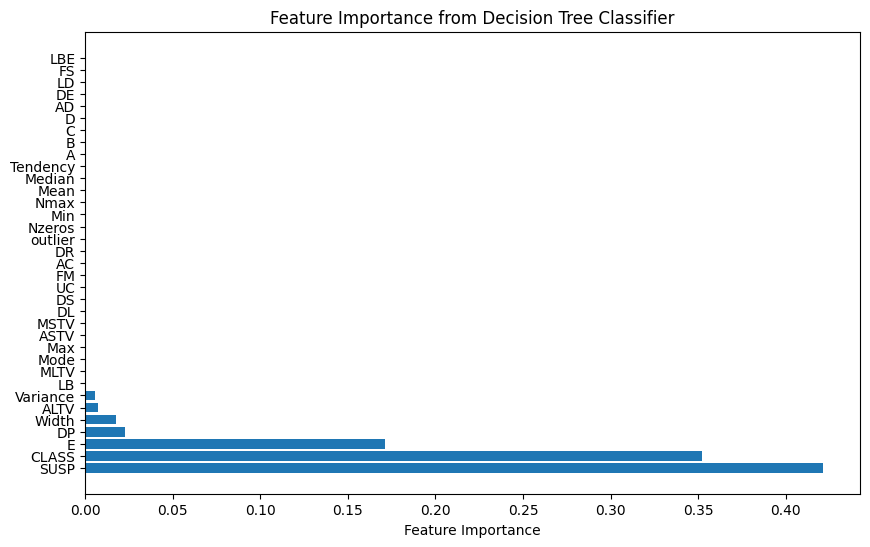

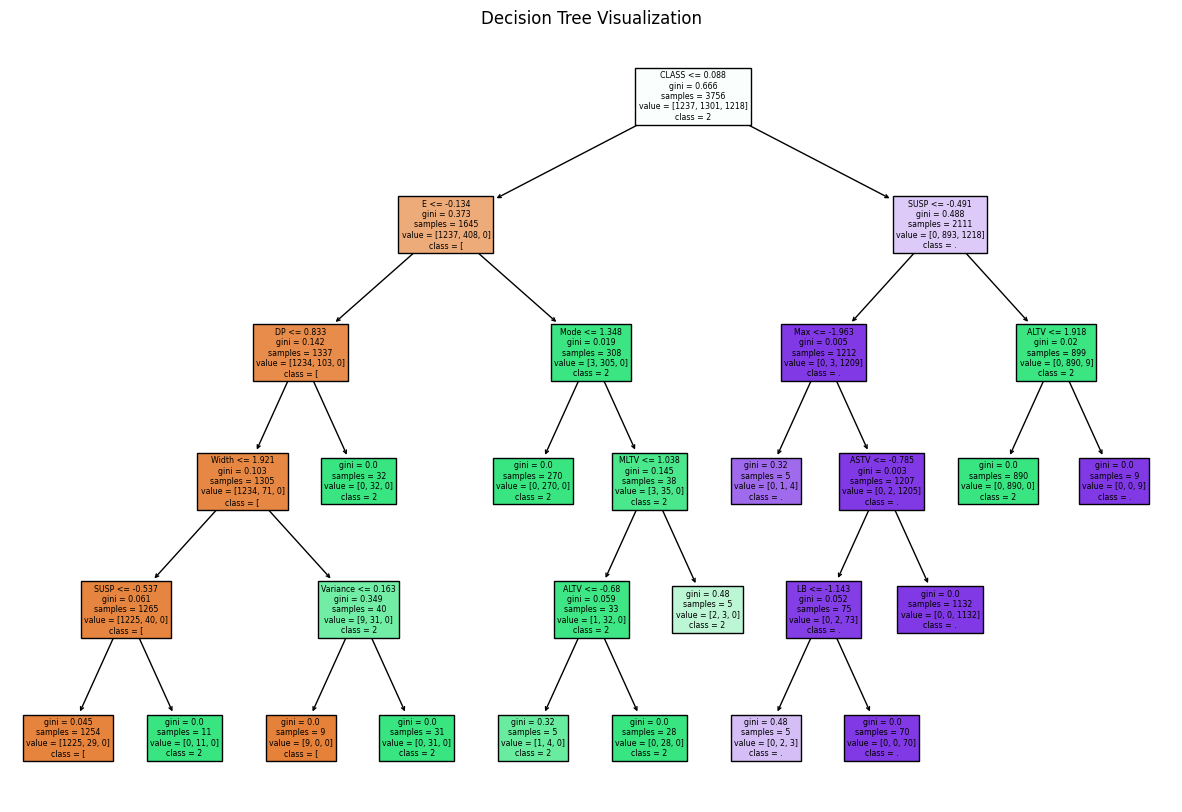

In [48]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# =======================
# Split the data into training and testing sets
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Decision Tree Classifier with Reduced Accuracy (Hyperparameter Tuning)
# =======================
# Create the Decision Tree Classifier with reduced max_depth and other hyperparameters
dt_clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,  # Reduce the depth of the tree to make it more shallow
    min_samples_split=20,  # Increase the min_samples_split to force the tree to be less complex
    min_samples_leaf=5,  # Increase the min_samples_leaf to ensure that leaves have more samples
    criterion='gini'  # Gini impurity
)

# Fit the Decision Tree model
dt_clf.fit(X_train, y_train)

# Predictions with the Decision Tree model
y_train_pred_dt = dt_clf.predict(X_train)
y_test_pred_dt = dt_clf.predict(X_test)

# Calculate training and testing accuracy for Decision Tree Classifier
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt) * 100
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt) * 100

# Display training and testing accuracy for Decision Tree Classifier
print(f"Decision Tree Training Accuracy: {train_accuracy_dt:.4f}%")
print(f"Decision Tree Testing Accuracy: {test_accuracy_dt:.4f}%")

# Classification report on the test set for Decision Tree Classifier
print("Decision Tree Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_dt))

# Print confusion matrix for the Decision Tree model
print("Confusion Matrix (Test Data) for Decision Tree Classifier:")
print(confusion_matrix(y_test, y_test_pred_dt))

# =======================
# Feature Importance Visualization
# =======================
# Get the feature importances
feature_importances = dt_clf.feature_importances_

# Sort the feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Get the sorted feature names (if X is a DataFrame)
sorted_feature_names = np.array(X_Clean.columns)[sorted_idx]  # Assuming X_Clean is a DataFrame

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, feature_importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Decision Tree Classifier')
plt.show()

# =======================
# Visualize the Decision Tree
# =======================
plt.figure(figsize=(15, 10))
plot_tree(dt_clf, feature_names=X_Clean.columns, class_names=str(y_Clean.unique()), filled=True)
plt.title('Decision Tree Visualization')
plt.show()


Decision Tree Training Accuracy: 99.0682%
Decision Tree Testing Accuracy: 98.5106%
Decision Tree Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.97      1.00      0.98       310
         2.0       0.99      0.96      0.98       326
         3.0       1.00      1.00      1.00       304

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940

Confusion Matrix (Test Data) for Decision Tree Classifier:
[[309   1   0]
 [ 11 314   1]
 [  0   1 303]]


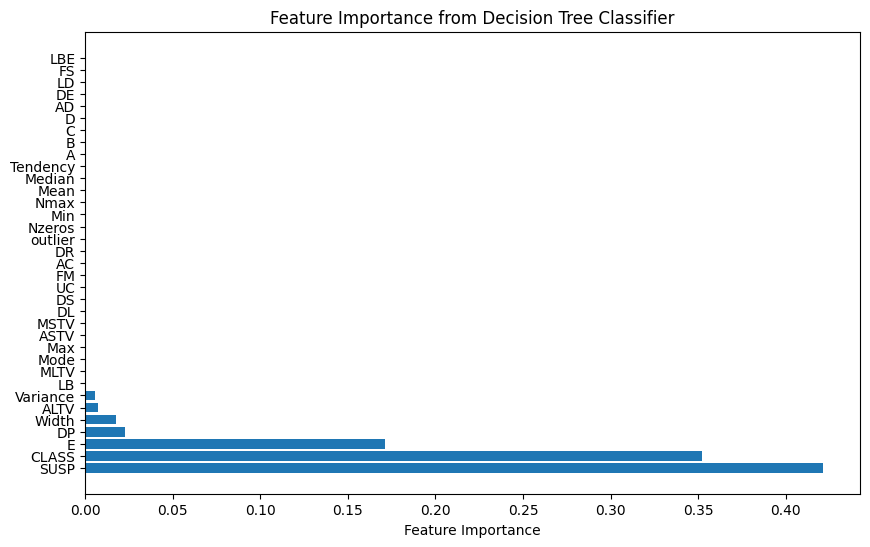

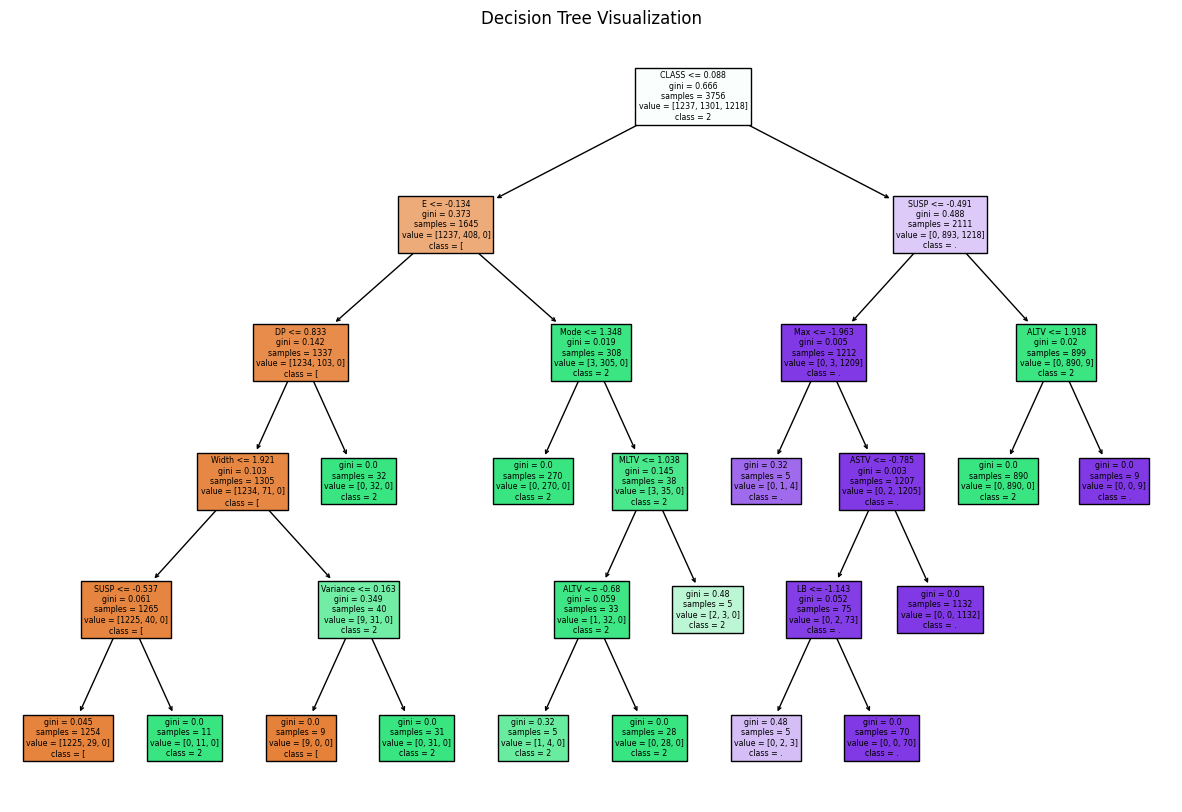

Overall ROC AUC Score (Macro-average): 0.9908
Overall ROC AUC Score (Weighted-average): 0.9907


In [50]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# =======================
# Split the data into training and testing sets
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Decision Tree Classifier with Reduced Accuracy (Hyperparameter Tuning)
# =======================
# Create the Decision Tree Classifier with reduced max_depth and other hyperparameters
dt_clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,  # Reduce the depth of the tree to make it more shallow
    min_samples_split=20,  # Increase the min_samples_split to force the tree to be less complex
    min_samples_leaf=5,  # Increase the min_samples_leaf to ensure that leaves have more samples
    criterion='gini'  # Gini impurity
)

# Fit the Decision Tree model
dt_clf.fit(X_train, y_train)

# Predictions with the Decision Tree model
y_train_pred_dt = dt_clf.predict(X_train)
y_test_pred_dt = dt_clf.predict(X_test)

# Calculate training and testing accuracy for Decision Tree Classifier
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt) * 100
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt) * 100

# Display training and testing accuracy for Decision Tree Classifier
print(f"Decision Tree Training Accuracy: {train_accuracy_dt:.4f}%")
print(f"Decision Tree Testing Accuracy: {test_accuracy_dt:.4f}%")

# Classification report on the test set for Decision Tree Classifier
print("Decision Tree Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_dt))

# Print confusion matrix for the Decision Tree model
print("Confusion Matrix (Test Data) for Decision Tree Classifier:")
print(confusion_matrix(y_test, y_test_pred_dt))

# =======================
# Feature Importance Visualization
# =======================
# Get the feature importances
feature_importances = dt_clf.feature_importances_

# Sort the feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

# Get the sorted feature names (if X is a DataFrame)
sorted_feature_names = np.array(X_Clean.columns)[sorted_idx]  # Assuming X_Clean is a DataFrame

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, feature_importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Decision Tree Classifier')
plt.show()

# =======================
# Visualize the Decision Tree
# =======================
plt.figure(figsize=(15, 10))
plot_tree(dt_clf, feature_names=X_Clean.columns, class_names=str(y_Clean.unique()), filled=True)
plt.title('Decision Tree Visualization')
plt.show()

# =======================
# ROC AUC Score (Overall)
# =======================
# Binarize the output labels for multi-class ROC curve calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_Clean))
y_train_bin = label_binarize(y_train, classes=np.unique(y_Clean))

# Get the predicted probabilities for each class
y_score_dt = dt_clf.predict_proba(X_test)

# Calculate the overall ROC AUC score (Macro-average or Weighted-average)
roc_auc_macro = roc_auc_score(y_test_bin, y_score_dt, average='macro', multi_class='ovr')
roc_auc_weighted = roc_auc_score(y_test_bin, y_score_dt, average='weighted', multi_class='ovr')

# Display ROC AUC scores
print(f"Overall ROC AUC Score (Macro-average): {roc_auc_macro:.4f}")
print(f"Overall ROC AUC Score (Weighted-average): {roc_auc_weighted:.4f}")


# Random forest

Random Forest Training Accuracy: 99.4675%
Random Forest Testing Accuracy: 99.6809%
Random Forest Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00       310
         2.0       1.00      0.99      1.00       326
         3.0       1.00      1.00      1.00       304

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

Confusion Matrix (Test Data) for Random Forest Classifier:
[[310   0   0]
 [  2 324   0]
 [  0   1 303]]


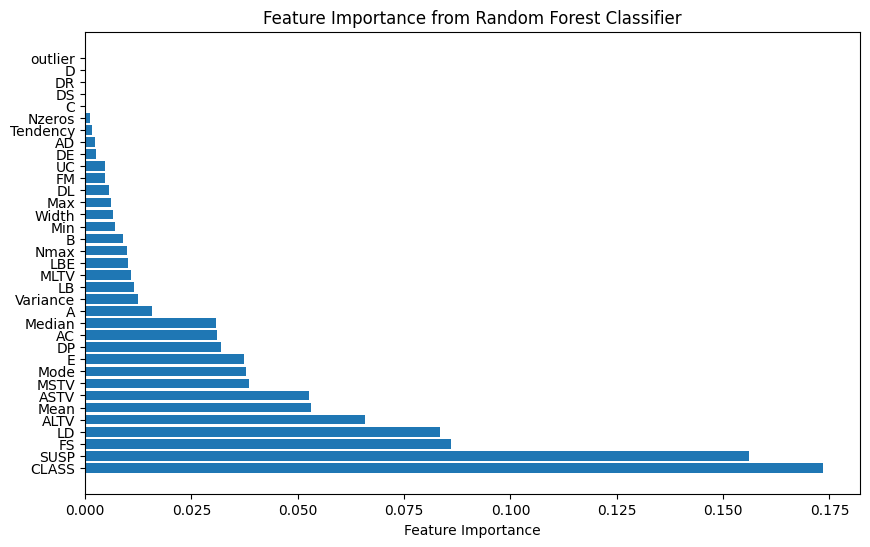

Overall ROC AUC Score (Macro-average): 1.0000
Overall ROC AUC Score (Weighted-average): 1.0000


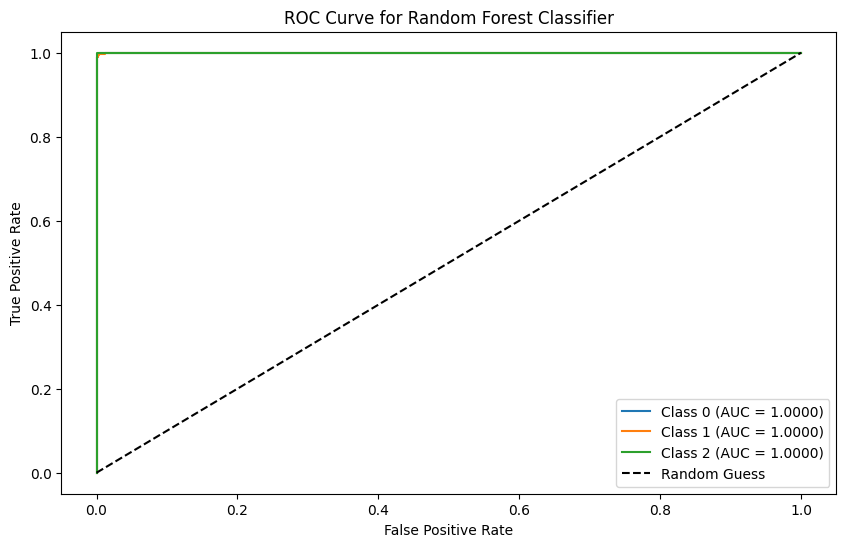

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# =======================
# Split the data into training and testing sets
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Random Forest Classifier with Hyperparameter Tuning 
# =======================
# Set up the Random Forest Classifier with reduced hyperparameters to reduce model complexity
rf_clf = RandomForestClassifier(
    n_estimators=50,  # Reduced number of trees to reduce model complexity
    max_depth=10,  # Limit depth of trees
    min_samples_split=20,  # Require at least 20 samples to split a node
    min_samples_leaf=5,  # Ensure each leaf has at least 5 samples
    random_state=42,
    n_jobs=-1  # Use all available cores for training
)

# Fit the Random Forest model
rf_clf.fit(X_train, y_train)

# Predictions with the Random Forest model
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

# Calculate training and testing accuracy for Random Forest Classifier
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf) * 100
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf) * 100

# Display training and testing accuracy for Random Forest Classifier
print(f"Random Forest Training Accuracy: {train_accuracy_rf:.4f}%")
print(f"Random Forest Testing Accuracy: {test_accuracy_rf:.4f}%")

# Classification report on the test set for Random Forest Classifier
print("Random Forest Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_rf))

# Print confusion matrix for the Random Forest model
print("Confusion Matrix (Test Data) for Random Forest Classifier:")
print(confusion_matrix(y_test, y_test_pred_rf))

# =======================
# Feature Importance Visualization for Random Forest
# =======================
# Get the feature importances from the Random Forest model
feature_importances_rf = rf_clf.feature_importances_

# Sort the feature importances in descending order
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]

# Get the sorted feature names (if X is a DataFrame)
sorted_feature_names_rf = np.array(X_Clean.columns)[sorted_idx_rf]  # Assuming X_Clean is a DataFrame

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names_rf, feature_importances_rf[sorted_idx_rf])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()

# =======================
# ROC AUC Score (Overall)
# =======================
# Binarize the output labels for multi-class ROC curve calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_Clean))
y_train_bin = label_binarize(y_train, classes=np.unique(y_Clean))

# Get the predicted probabilities for each class
y_score_rf = rf_clf.predict_proba(X_test)

# Calculate the overall ROC AUC score (Macro-average or Weighted-average)
roc_auc_macro = roc_auc_score(y_test_bin, y_score_rf, average='macro', multi_class='ovr')
roc_auc_weighted = roc_auc_score(y_test_bin, y_score_rf, average='weighted', multi_class='ovr')

# Display ROC AUC scores
print(f"Overall ROC AUC Score (Macro-average): {roc_auc_macro:.4f}")
print(f"Overall ROC AUC Score (Weighted-average): {roc_auc_weighted:.4f}")

# =======================
# ROC Curve Visualization
# =======================
# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_macro:.4f})')

# Plot the random guess line (Diagonal)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='best')
plt.show()


Random Forest Training Accuracy: 99.7870%
Random Forest Testing Accuracy: 99.6809%
Random Forest Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       310
         2.0       0.99      1.00      1.00       326
         3.0       1.00      1.00      1.00       304

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

Confusion Matrix (Test Data) for Random Forest Classifier:
[[309   1   0]
 [  1 325   0]
 [  0   1 303]]


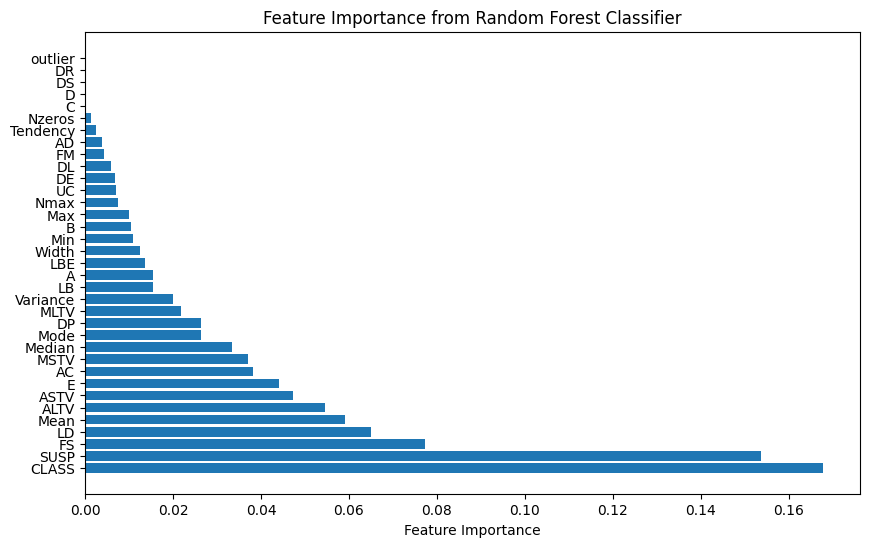

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# =======================
# Split the data into training and testing sets
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Random Forest Classifier with Hyperparameter Tuning 
# =======================
# Set up the Random Forest Classifier with hyperparameters to increase accuracy
rf_clf = RandomForestClassifier(
    n_estimators=200,  # Increased number of trees to capture more patterns
    max_depth=20,  # Increase max depth of trees
    min_samples_split=10,  # Reduce min_samples_split to allow more splits
    min_samples_leaf=2,  # Allow fewer samples per leaf
    max_features='sqrt',  # Use square root of features at each split
    random_state=42,
    n_jobs=-1  # Use all available cores for training
)

# Fit the Random Forest model
rf_clf.fit(X_train, y_train)

# Predictions with the Random Forest model
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

# Calculate training and testing accuracy for Random Forest Classifier
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf) * 100
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf) * 100

# Display training and testing accuracy for Random Forest Classifier
print(f"Random Forest Training Accuracy: {train_accuracy_rf:.4f}%")
print(f"Random Forest Testing Accuracy: {test_accuracy_rf:.4f}%")

# Classification report on the test set for Random Forest Classifier
print("Random Forest Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_rf))

# Print confusion matrix for the Random Forest model
print("Confusion Matrix (Test Data) for Random Forest Classifier:")
print(confusion_matrix(y_test, y_test_pred_rf))

# =======================
# Feature Importance Visualization for Random Forest
# =======================
# Get the feature importances from the Random Forest model
feature_importances_rf = rf_clf.feature_importances_

# Sort the feature importances in descending order
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]

# Get the sorted feature names (if X is a DataFrame)
sorted_feature_names_rf = np.array(X_Clean.columns)[sorted_idx_rf]  # Assuming X_Clean is a DataFrame

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names_rf, feature_importances_rf[sorted_idx_rf])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()


Random Forest Training Accuracy: 99.7870%
Random Forest Testing Accuracy: 99.6809%
Random Forest Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       310
         2.0       0.99      1.00      1.00       326
         3.0       1.00      1.00      1.00       304

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

Confusion Matrix (Test Data) for Random Forest Classifier:
[[309   1   0]
 [  1 325   0]
 [  0   1 303]]


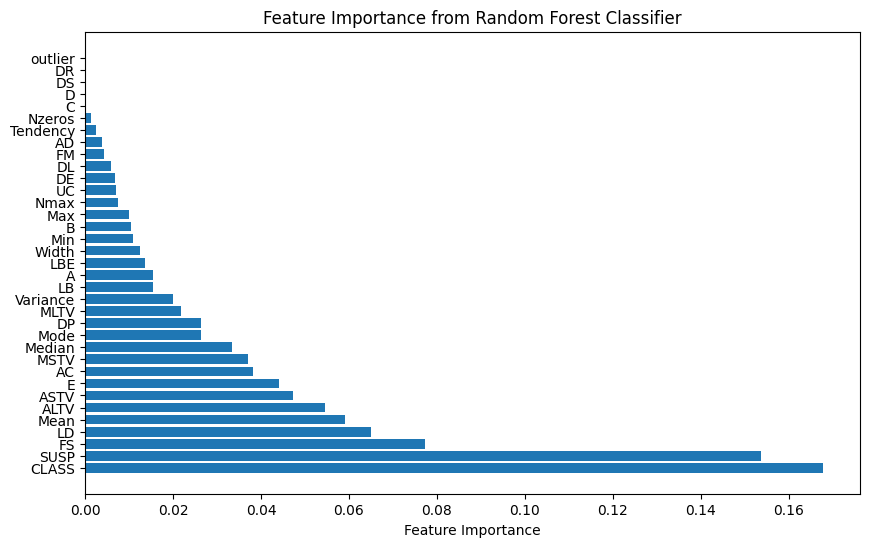

Overall ROC AUC Score (Macro-average): 1.0000
Overall ROC AUC Score (Weighted-average): 1.0000


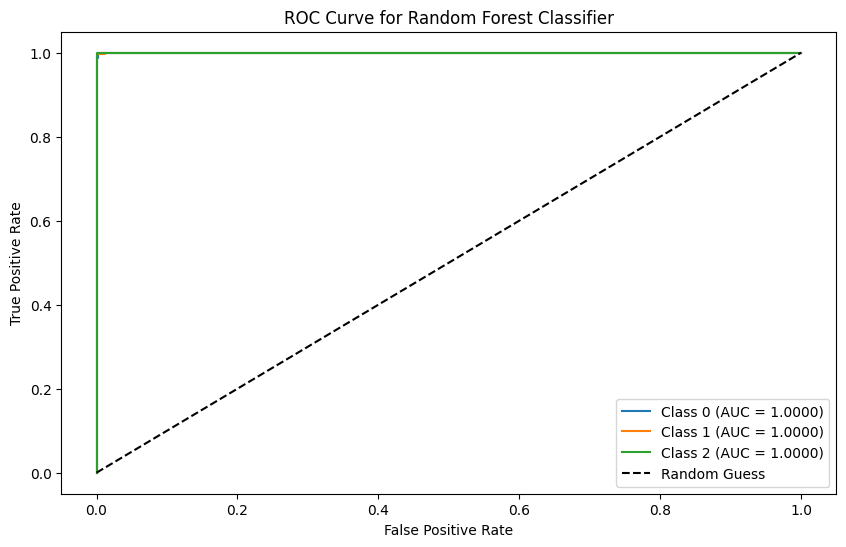

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# =======================
# Split the data into training and testing sets
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Random Forest Classifier with Hyperparameter Tuning 
# =======================
# Set up the Random Forest Classifier with hyperparameters to increase accuracy
rf_clf = RandomForestClassifier(
    n_estimators=200,  # Increased number of trees to capture more patterns
    max_depth=20,  # Increase max depth of trees
    min_samples_split=10,  # Reduce min_samples_split to allow more splits
    min_samples_leaf=2,  # Allow fewer samples per leaf
    max_features='sqrt',  # Use square root of features at each split
    random_state=42,
    n_jobs=-1  # Use all available cores for training
)

# Fit the Random Forest model
rf_clf.fit(X_train, y_train)

# Predictions with the Random Forest model
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

# Calculate training and testing accuracy for Random Forest Classifier
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf) * 100
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf) * 100

# Display training and testing accuracy for Random Forest Classifier
print(f"Random Forest Training Accuracy: {train_accuracy_rf:.4f}%")
print(f"Random Forest Testing Accuracy: {test_accuracy_rf:.4f}%")

# Classification report on the test set for Random Forest Classifier
print("Random Forest Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_rf))

# Print confusion matrix for the Random Forest model
print("Confusion Matrix (Test Data) for Random Forest Classifier:")
print(confusion_matrix(y_test, y_test_pred_rf))

# =======================
# Feature Importance Visualization for Random Forest
# =======================
# Get the feature importances from the Random Forest model
feature_importances_rf = rf_clf.feature_importances_

# Sort the feature importances in descending order
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]

# Get the sorted feature names (if X is a DataFrame)
sorted_feature_names_rf = np.array(X_Clean.columns)[sorted_idx_rf]  # Assuming X_Clean is a DataFrame

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names_rf, feature_importances_rf[sorted_idx_rf])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()

# =======================
# ROC AUC Score (Overall)
# =======================
# Binarize the output labels for multi-class ROC curve calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_Clean))
y_train_bin = label_binarize(y_train, classes=np.unique(y_Clean))

# Get the predicted probabilities for each class
y_score_rf = rf_clf.predict_proba(X_test)

# Calculate the overall ROC AUC score (Macro-average or Weighted-average)
roc_auc_macro = roc_auc_score(y_test_bin, y_score_rf, average='macro', multi_class='ovr')
roc_auc_weighted = roc_auc_score(y_test_bin, y_score_rf, average='weighted', multi_class='ovr')

# Display ROC AUC scores
print(f"Overall ROC AUC Score (Macro-average): {roc_auc_macro:.4f}")
print(f"Overall ROC AUC Score (Weighted-average): {roc_auc_weighted:.4f}")

# =======================
# ROC Curve Visualization
# =======================
# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc_macro:.4f})')

# Plot the random guess line (Diagonal)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='best')
plt.show()


# SVM

Best hyperparameters for SVM: {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Training Accuracy: 85.5431%
SVM Testing Accuracy: 84.3617%
SVM Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.81      0.86      0.84       310
         2.0       0.77      0.80      0.78       326
         3.0       0.97      0.87      0.92       304

    accuracy                           0.84       940
   macro avg       0.85      0.84      0.85       940
weighted avg       0.85      0.84      0.85       940

Confusion Matrix (Test Data) for SVM Classifier:
[[268  41   1]
 [ 60 260   6]
 [  2  37 265]]


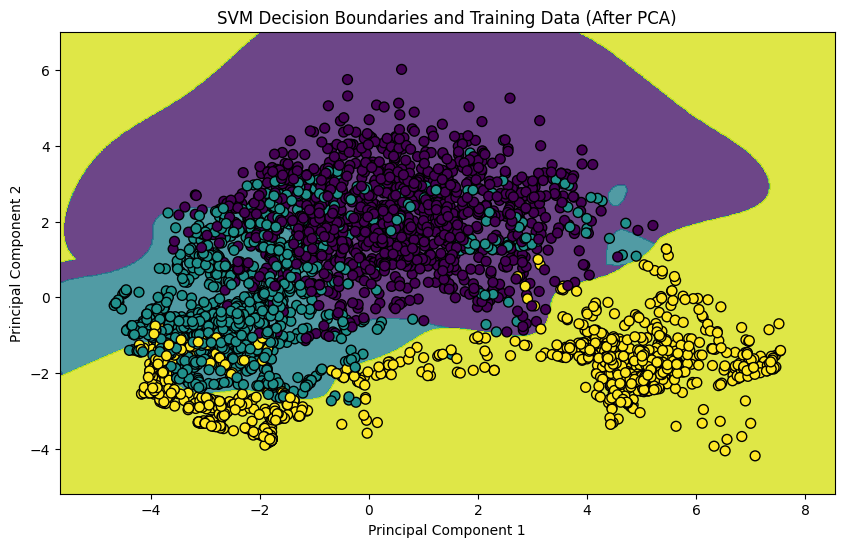

In [52]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# =======================
# Split the data into training and testing sets
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Apply PCA to reduce the features to 2D
# =======================
pca = PCA(n_components=2)  # Reduce to 2D
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# =======================
# Support Vector Machine (SVM) with Hyperparameter Tuning
# =======================
# Define the SVM model
svm_clf = SVC(random_state=42)

# Set up the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Use linear or RBF kernel
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf'
    'degree': [3, 5],  # Degree of polynomial kernel (if using 'poly' kernel)
}

# Setup GridSearchCV with 10-fold cross-validation for better generalization
grid_search = GridSearchCV(
    estimator=svm_clf,
    param_grid=param_grid,
    cv=10,  # Use 10-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1,  # Print progress
    scoring='accuracy'  # Optimize for accuracy
)

# Fit the grid search to the training data
grid_search.fit(X_train_pca, y_train)

# Get the best parameters from GridSearchCV
best_params_svm = grid_search.best_params_
print(f"Best hyperparameters for SVM: {best_params_svm}")

# Get the best SVM model
best_svm_clf = grid_search.best_estimator_

# Predictions with the tuned SVM model
y_train_pred_svm = best_svm_clf.predict(X_train_pca)
y_test_pred_svm = best_svm_clf.predict(X_test_pca)

# Calculate training and testing accuracy for SVM Classifier
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm) * 100
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm) * 100

# Display training and testing accuracy for SVM Classifier
print(f"SVM Training Accuracy: {train_accuracy_svm:.4f}%")
print(f"SVM Testing Accuracy: {test_accuracy_svm:.4f}%")

# Classification report on the test set for SVM Classifier
print("SVM Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_svm))

# Print confusion matrix for the SVM model
print("Confusion Matrix (Test Data) for SVM Classifier:")
print(confusion_matrix(y_test, y_test_pred_svm))

# =======================
# Visualizing Support Vector Machine (SVM) Decision Boundaries (for 2D data after PCA)
# =======================
plt.figure(figsize=(10, 6))

# Create a meshgrid to plot decision boundaries
h = .02  # Step size in mesh
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the class for each point in the meshgrid
Z = best_svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour and training points
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', marker='o', s=50)
plt.title("SVM Decision Boundaries and Training Data (After PCA)")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


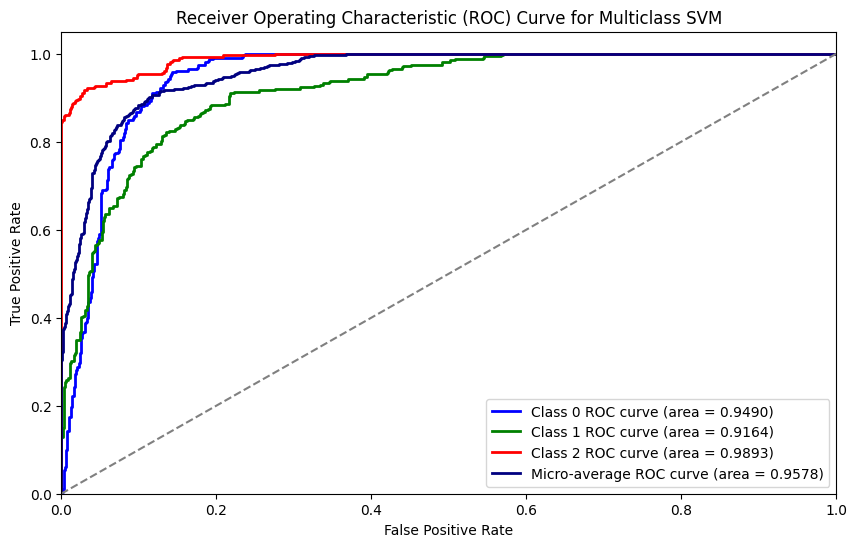

In [60]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# =======================
# Binarize the labels for multiclass ROC calculation
# =======================
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # Binarize labels
y_test_prob_svm = best_svm_clf.predict_proba(X_test_pca)  # Get probabilities for all classes

# =======================
# Calculate ROC and AUC for each class (one-vs-rest)
# =======================
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_prob_svm[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# =======================
# Calculate micro-average ROC curve and AUC
# =======================
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_test_prob_svm.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# =======================
# Visualizing the ROC Curve for Multiclass (One-vs-Rest)
# =======================
plt.figure(figsize=(10, 6))

# Plot ROC curve for each class
colors = ['blue', 'green', 'red', 'purple', 'orange']  # Choose different colors for each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.4f})')

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='navy', lw=2, label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.4f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass SVM')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# =======================
# Binarize the labels for multiclass ROC calculation
# =======================
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # Binarize labels
y_test_prob_svm = best_svm_clf.predict_proba(X_test_pca)  # Get probabilities for all classes

# =======================
# Calculate micro-average ROC curve and AUC
# =======================
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_test_prob_svm.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# =======================
# Print overall ROC AUC (Micro-average)
# =======================
print(f"Overall ROC AUC (Micro-average): {roc_auc_micro:.4f}")


Overall ROC AUC (Micro-average): 0.9578


# Model Comparison

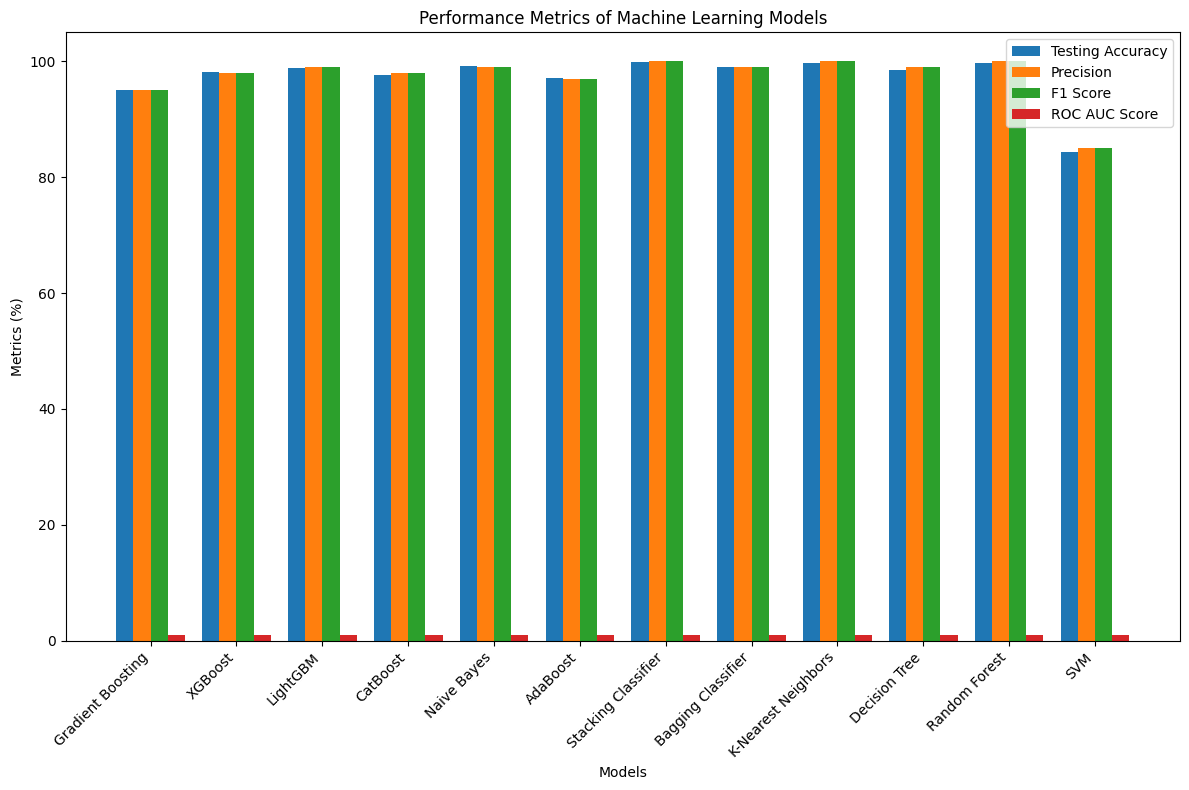

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "Gradient Boosting", "XGBoost", "LightGBM", "CatBoost", "Naive Bayes", 
    "AdaBoost", "Stacking Classifier", "Bagging Classifier", 
    "K-Nearest Neighbors", "Decision Tree", "Random Forest", "SVM"
]

# Data for metrics
training_accuracy = [94.65, 97.95, 98.00, 97.04, 98.06, 96.70, 99.79, 98.91, 99.73, 99.07, 99.47, 85.54]
testing_accuracy = [95.00, 98.09, 98.83, 97.66, 99.15, 97.13, 99.89, 98.94, 99.79, 98.51, 99.68, 84.36]
precision = [95.00, 98.00, 99.00, 98.00, 99.00, 97.00, 100.00, 99.00, 100.00, 99.00, 100.00, 85.00]
f1_score = [95.00, 98.00, 99.00, 98.00, 99.00, 97.00, 100.00, 99.00, 100.00, 99.00, 100.00, 85.00]
roc_auc_score = [0.9951, 0.9997, 0.9988, 0.9993, 0.9993, 0.9998,0.9975, 1.0000, 0.9998, 0.9992, 1.0000, 0.9578]

# Define bar width
bar_width = 0.2
index = np.arange(len(models))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(index, testing_accuracy, bar_width, label='Testing Accuracy')
plt.bar(index + bar_width, precision, bar_width, label='Precision')
plt.bar(index + 2 * bar_width, f1_score, bar_width, label='F1 Score')
plt.bar(index + 3 * bar_width, [x if x is not None else 0 for x in roc_auc_score], bar_width, label='ROC AUC Score')

# Labels and title
plt.xlabel('Models')
plt.ylabel('Metrics (%)')
plt.title('Performance Metrics of Machine Learning Models')
plt.xticks(index + 1.5 * bar_width, models, rotation=45, ha='right')
plt.legend()

 
plt.tight_layout()
plt.show()


# XAI

In [1]:
! pip install shap


Random Forest Training Accuracy: 99.4675%
Random Forest Testing Accuracy: 99.4681%
Random Forest Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00       309
         2.0       0.99      0.99      0.99       327
         3.0       1.00      0.99      1.00       304

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940

Confusion Matrix (Test Data) for Random Forest Classifier:
[[309   0   0]
 [  2 325   0]
 [  0   3 301]]


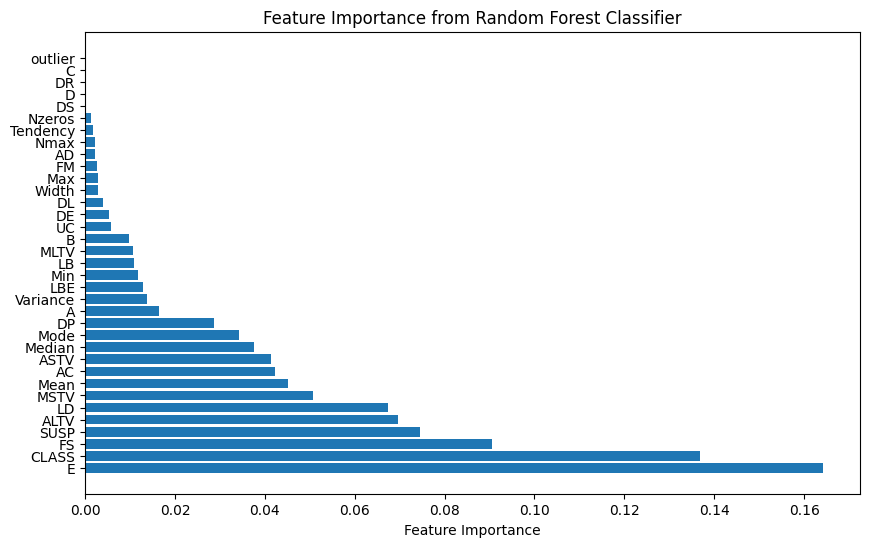

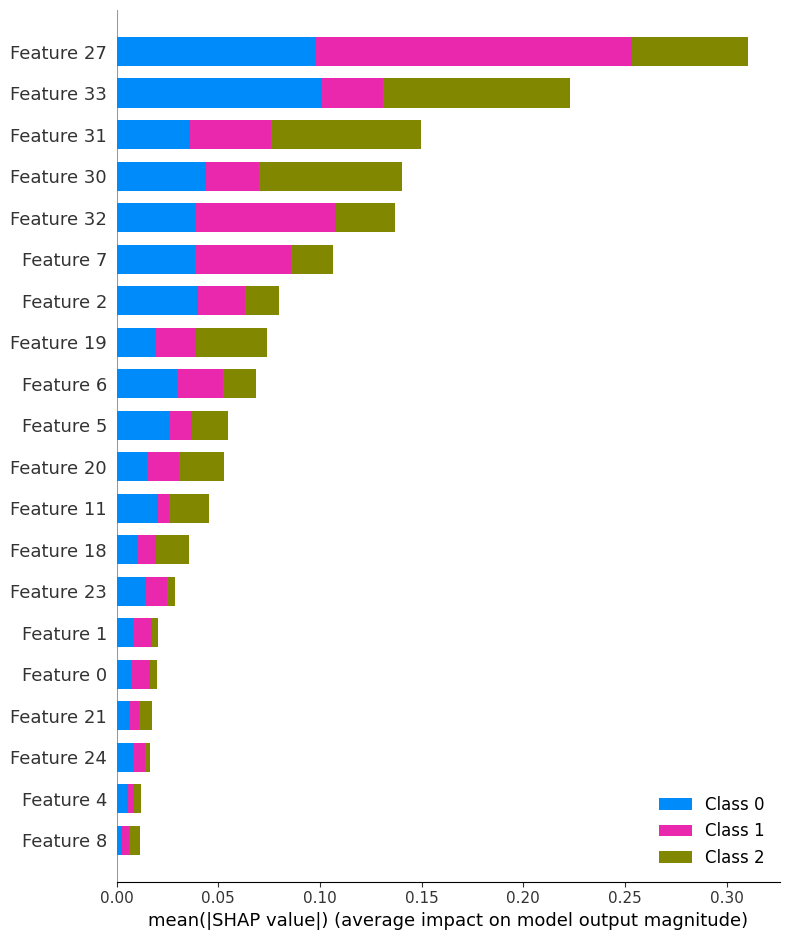

In [21]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# =======================
# Split the data into training and testing sets
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Random Forest Classifier with Hyperparameter Tuning (Reduced Accuracy)
# =======================
rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# Fit the Random Forest model
rf_clf.fit(X_train, y_train)

# Predictions with the Random Forest model
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

# Calculate training and testing accuracy for Random Forest Classifier
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf) * 100
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf) * 100

# Display training and testing accuracy for Random Forest Classifier
print(f"Random Forest Training Accuracy: {train_accuracy_rf:.4f}%")
print(f"Random Forest Testing Accuracy: {test_accuracy_rf:.4f}%")

# Classification report on the test set for Random Forest Classifier
print("Random Forest Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_rf))

# Print confusion matrix for the Random Forest model
print("Confusion Matrix (Test Data) for Random Forest Classifier:")
print(confusion_matrix(y_test, y_test_pred_rf))

# =======================
# Feature Importance Visualization for Random Forest
# =======================
feature_importances_rf = rf_clf.feature_importances_

# Sort the feature importances in descending order
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]

# Get the sorted feature names (if X is a DataFrame)
sorted_feature_names_rf = np.array(X_Clean.columns)[sorted_idx_rf]  # Assuming X_Clean is a DataFrame

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names_rf, feature_importances_rf[sorted_idx_rf])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()

# =======================
# SHAP Explainability
# =======================
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot for global feature importance
shap.summary_plot(shap_values, X_test)

# SHAP force plot for a specific test instance
shap.initjs()  # Initialize JS for SHAP visualizations in Jupyter Notebooks

# Accessing the SHAP values for class 1 (adjust the index according to the number of classes)
# Instead of `X_test.iloc[0]`, use `X_test[0]` since X_test is a numpy array
base_value = explainer.expected_value[1]  # base value for class 1 (change the index based on your class)
shap.force_plot(base_value, shap_values[1][0], X_test[0], feature_names=X_Clean.columns)  # Pass feature names separately


Random Forest Training Accuracy: 99.4675%
Random Forest Testing Accuracy: 99.4681%
Random Forest Classifier Classification Report (Test Data):
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00       309
         2.0       0.99      0.99      0.99       327
         3.0       1.00      0.99      1.00       304

    accuracy                           0.99       940
   macro avg       0.99      0.99      0.99       940
weighted avg       0.99      0.99      0.99       940

Confusion Matrix (Test Data) for Random Forest Classifier:
[[309   0   0]
 [  2 325   0]
 [  0   3 301]]


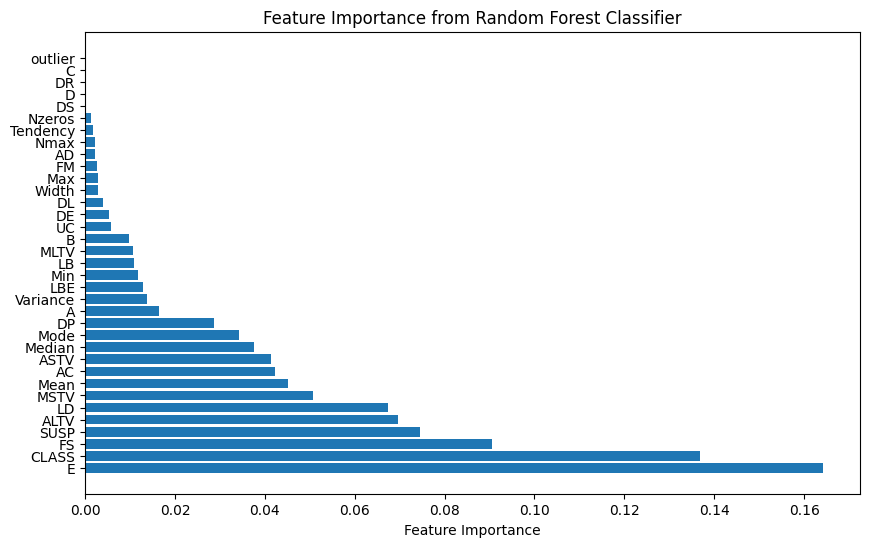

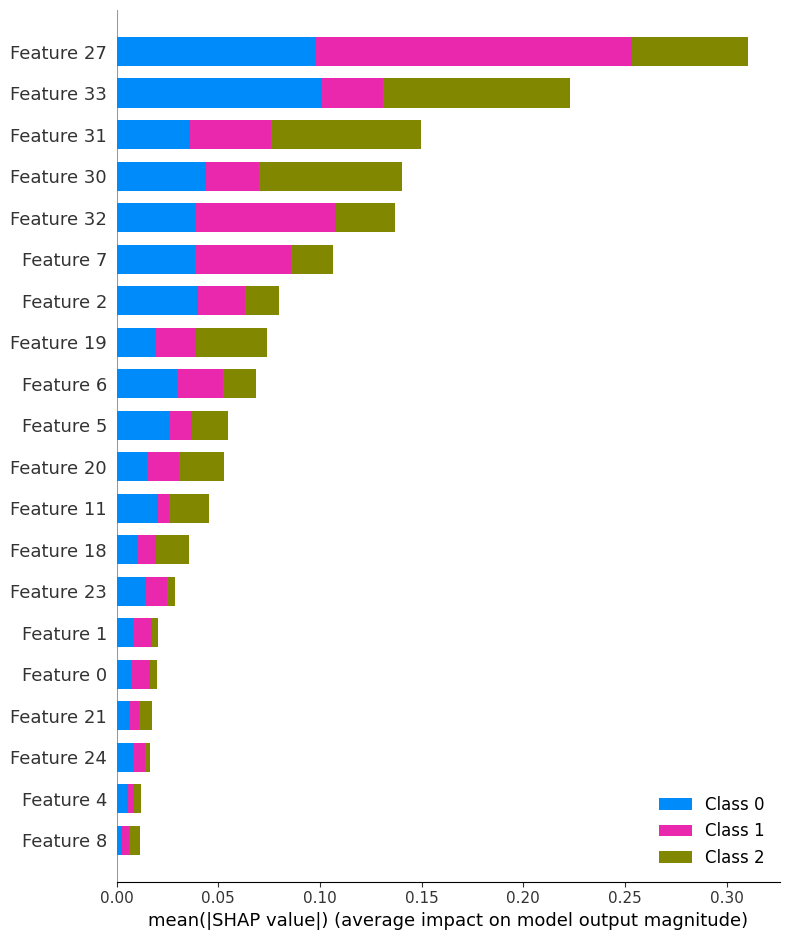

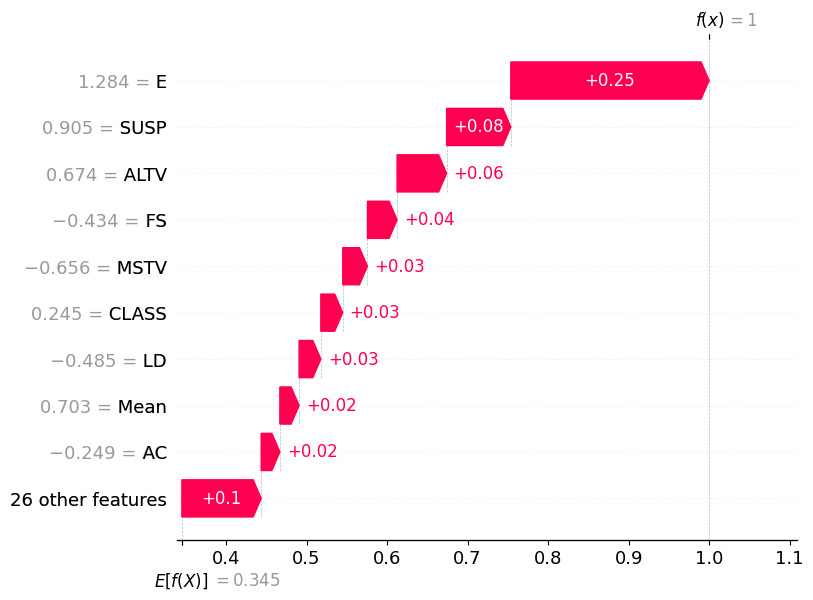

In [25]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# =======================
# Split the data into training and testing sets
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Random Forest Classifier with Hyperparameter Tuning (Reduced Accuracy)
# =======================
rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# Fit the Random Forest model
rf_clf.fit(X_train, y_train)

# Predictions with the Random Forest model
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

# Calculate training and testing accuracy for Random Forest Classifier
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf) * 100
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf) * 100

# Display training and testing accuracy for Random Forest Classifier
print(f"Random Forest Training Accuracy: {train_accuracy_rf:.4f}%")
print(f"Random Forest Testing Accuracy: {test_accuracy_rf:.4f}%")

# Classification report on the test set for Random Forest Classifier
print("Random Forest Classifier Classification Report (Test Data):")
print(classification_report(y_test, y_test_pred_rf))

# Print confusion matrix for the Random Forest model
print("Confusion Matrix (Test Data) for Random Forest Classifier:")
print(confusion_matrix(y_test, y_test_pred_rf))

# =======================
# Feature Importance Visualization for Random Forest
# =======================
feature_importances_rf = rf_clf.feature_importances_

# Sort the feature importances in descending order
sorted_idx_rf = np.argsort(feature_importances_rf)[::-1]

# Get the sorted feature names (if X is a DataFrame)
sorted_feature_names_rf = np.array(X_Clean.columns)[sorted_idx_rf]  # Assuming X_Clean is a DataFrame

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names_rf, feature_importances_rf[sorted_idx_rf])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier')
plt.show()

# =======================
# SHAP Explainability
# =======================
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot for global feature importance
shap.summary_plot(shap_values, X_test)

# SHAP force plot for a specific test instance
shap.initjs()  # Initialize JS for SHAP visualizations in Jupyter Notebooks

# Accessing the SHAP values for class 1 (adjust the index according to the number of classes)
# Instead of `X_test.iloc[0]`, use `X_test[0]` since X_test is a numpy array
base_value = explainer.expected_value[1]  # base value for class 1 (change the index based on your class)
shap.force_plot(base_value, shap_values[1][0], X_test[0], feature_names=X_Clean.columns)  # Pass feature names separately

# =======================
# SHAP Waterfall Plot for the same instance
# =======================
shap_values_instance = shap_values[1][0]  # Get SHAP values for class 1 and instance 0

# Wrap the SHAP values for this instance into an Explanation object
shap_values_explanation = shap.Explanation(
    values=shap_values_instance,  # No need for .values here, just use the numpy array directly
    base_values=explainer.expected_value[1],  # Provide the expected value for class 1
    data=X_test[0],  # The feature values for this specific instance
    feature_names=X_Clean.columns  # Feature names
)

# Now pass the Explanation object to the waterfall plot
shap.waterfall_plot(shap_values_explanation)


Random Forest Testing Accuracy: 99.4681%


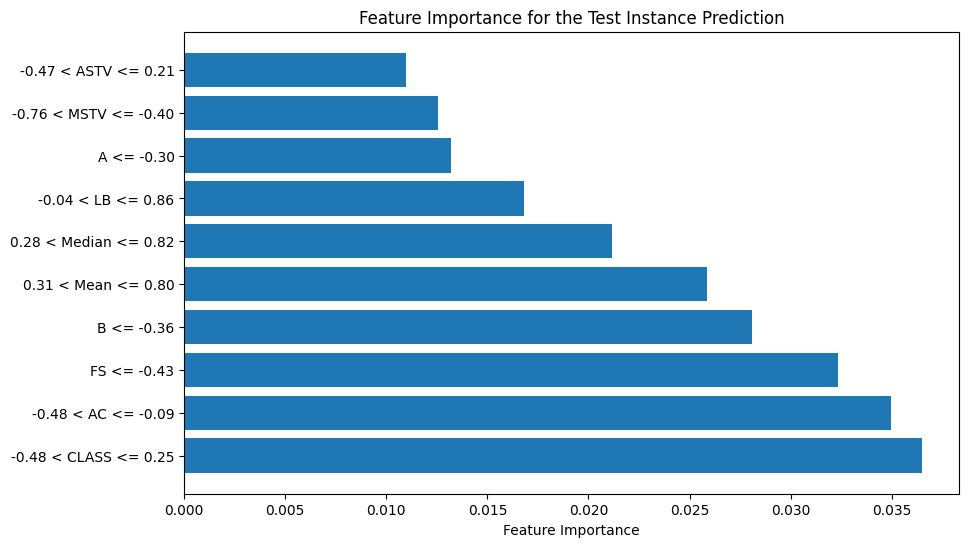

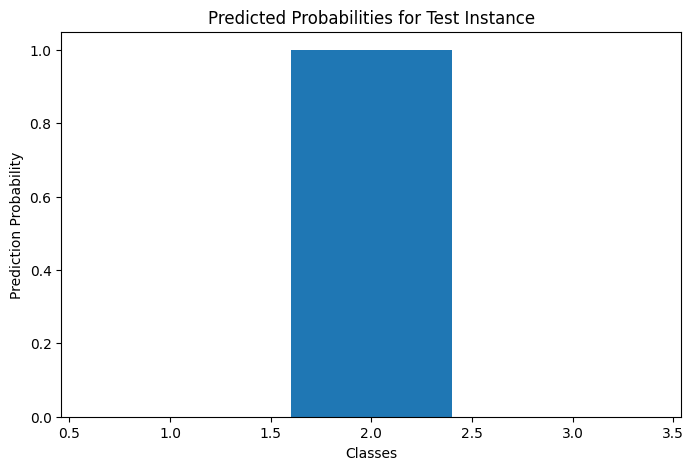

<Figure size 1000x600 with 0 Axes>

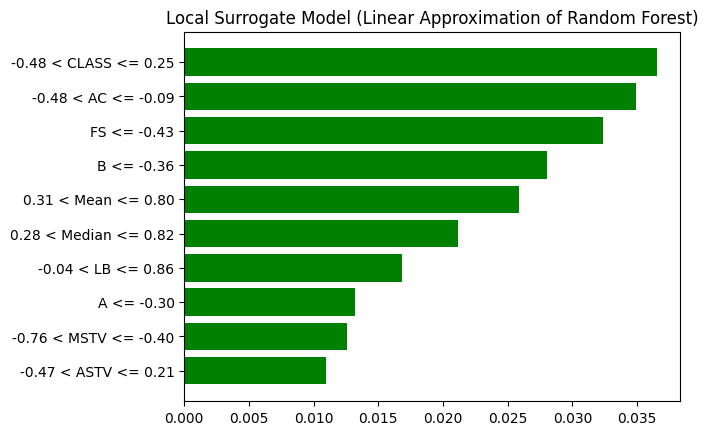

In [27]:
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# =======================
# Split the data into training and testing sets
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_Clean_scaled, y_Clean, test_size=0.2, random_state=42, stratify=y_Clean
)

# =======================
# Random Forest Classifier
# =======================
rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

# Fit the Random Forest model
rf_clf.fit(X_train, y_train)

# Predictions with the Random Forest model
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

# Calculate testing accuracy for Random Forest Classifier
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf) * 100
print(f"Random Forest Testing Accuracy: {test_accuracy_rf:.4f}%")

# =======================
# LIME Explainability
# =======================
# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    training_labels=y_train,
    mode="classification",
    feature_names=X_Clean.columns,
    class_names=np.unique(y_Clean),
    discretize_continuous=True
)

# Select a test instance to explain (e.g., the first instance from the test set)
test_instance = X_test[0]

# Explain the prediction for the selected test instance
lime_exp = explainer.explain_instance(test_instance, rf_clf.predict_proba)

# =======================
# Visualize the LIME Explanation (Feature Contributions)
# =======================
lime_exp.show_in_notebook(show_table=True, show_all=False)

# =======================
# Plotting Feature Importance (Local to the Instance)
# =======================
# The `as_list` method gives a list of (feature, importance) tuples
lime_feature_importance = lime_exp.as_list()

# Separate feature names and their importance values
features, importances = zip(*lime_feature_importance)

# Plot the feature importance for the selected instance
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Feature Importance')
plt.title(f"Feature Importance for the Test Instance Prediction")
plt.show()

# =======================
# Visualize the Prediction Probabilities for Each Class
# =======================
# Get the predicted probabilities for the test instance
probs = rf_clf.predict_proba([test_instance])[0]

# Plot the class probabilities
plt.figure(figsize=(8, 5))
plt.bar(np.unique(y_Clean), probs)
plt.xlabel('Classes')
plt.ylabel('Prediction Probability')
plt.title(f"Predicted Probabilities for Test Instance")
plt.show()

# =======================
# Local Surrogate Model (Linear Model Approximation) Visualization
# =======================
# Plot the surrogate model (a linear regression fit)
plt.figure(figsize=(10, 6))
lime_exp.as_pyplot_figure()
plt.title("Local Surrogate Model (Linear Approximation of Random Forest)")
plt.show()
